# Cell width

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Imports

In [2]:
%load_ext autoreload
%autoreload 2
import sys 

# sys.path.append('..')
from omegaconf import OmegaConf
from pprint import pprint
from dacite import from_dict
from dacite import Config as DaciteConfig
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np

import math
from abc import abstractmethod

from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig
from xlstm.utils import WeightDecayOptimGroupMixin

from xlstm_moex.data.download import get_historical_data, get_historical_candels

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Fucntions and classes

In [3]:
class BaseLRScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        super().__init__(optimizer, last_epoch)

    @abstractmethod
    def get_lr(self) -> list[float]:
        """Returns the current learning rate for each parameter group."""
        raise NotImplementedError

    @abstractmethod
    def reinitialize(self, **kwargs) -> None:
        """Reinitializes the learning rate scheduler."""
        raise NotImplementedError


class LinearWarmupCosineAnnealing(BaseLRScheduler):
    def __init__(self, optimizer, warmup_steps, decay_until_step, max_lr, min_lr, last_epoch=-1):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.decay_until_step = decay_until_step
        self.min_lr = min_lr
        self.max_lr = max_lr
        super().__init__(optimizer, last_epoch)

    @staticmethod
    def compute_lr(step, warmup_steps, decay_until_step, max_lr, min_lr):
        if step < warmup_steps:
            return max_lr * step / warmup_steps
        if step > decay_until_step:
            return min_lr
        if warmup_steps <= step < decay_until_step:
            decay_ratio = (step - warmup_steps) / (decay_until_step - warmup_steps)
            assert 0.0 <= decay_ratio <= 1.0
            coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
            return min_lr + coeff * (max_lr - min_lr)
        else:
            return min_lr

    def get_lr(self) -> list[float]:
        """Returns the current learning rate for each parameter group."""
        step = self.last_epoch
        return (
            self.compute_lr(step, self.warmup_steps, self.decay_until_step, self.max_lr, self.min_lr)
            for _ in self.optimizer.param_groups
        )

# Init config

In [2]:
# xlstm_cfg = f""" 
# mlstm_block:
#   mlstm:
#     conv1d_kernel_size: 4
#     qkv_proj_blocksize: 1
#     num_heads: 1
#     proj_factor: 1
# slstm_block:
#   slstm:
#     backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
#     num_heads: 1
#     conv1d_kernel_size: 0
#     bias_init: powerlaw_blockdependent
#   feedforward:
#     proj_factor: 1.2
#     act_fn: gelu
# context_length: 50
# num_blocks: 2
# embedding_dim: 1 # same as `in_features` in Pytorch LSTM
# slstm_at: [1] #[1] # for [] it also works, so if no sLSTM is in the stack
# """

xlstm_cfg = f""" 
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 4
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 256
num_blocks: 7
embedding_dim: 128
add_post_blocks_norm: False
slstm_at: [1] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

# Init XLSTM model

In [3]:
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
xlstm_stack = xLSTMBlockStack(cfg)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/nick/anaconda3/envs/nxai_xlstm/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vect

Using /home/nick/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/nick/.cache/torch_extensions/py311_cu121/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


# Inspect config

In [5]:
pprint(cfg.embedding_dim)

128


# Inspect layers

In [91]:
xlstm_stack

xLSTMBlockStack(
  (blocks): ModuleList(
    (0): mLSTMBlock(
      (xlstm_norm): LayerNorm()
      (xlstm): mLSTMLayer(
        (proj_up): Linear(in_features=128, out_features=512, bias=False)
        (q_proj): LinearHeadwiseExpand(in_features=256, num_heads=64, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
        (k_proj): LinearHeadwiseExpand(in_features=256, num_heads=64, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
        (v_proj): LinearHeadwiseExpand(in_features=256, num_heads=64, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
        (conv1d): CausalConv1d(
          (conv): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        )
        (conv_act_fn): SiLU()
        (mlstm_cell): mLSTMCell(
          (igate): Linear(in_features=768, out_features=4, bias=True)
          (fgate): Linear(in_features=768, out_features=4, bias=True)
          (outnorm): Mult

# Generate synthetic examlpe

In [122]:
x = torch.randn(2, 256, 128).to(device=device)

In [123]:
x.shape

torch.Size([2, 256, 128])

In [97]:
x[:, 1, :].view(2,1,128).shape

torch.Size([2, 1, 128])

# Check model's output

In [98]:
xlstm_stack = xlstm_stack.to(device=device)

In [84]:
for i in range(2):
    y, states_dict = xlstm_stack.step(x[:, i, :].view(2,1,128))

In [87]:
states_dict['block_6']

{'mlstm_state': (tensor([[[[ 5.4874e-06, -1.2764e-06, -4.2204e-06,  ..., -1.7712e-05,
             -2.4697e-06, -7.9438e-06],
            [ 4.2978e-05, -9.9968e-06, -3.3054e-05,  ..., -1.3872e-04,
             -1.9342e-05, -6.2216e-05],
            [-2.4128e-05,  5.6123e-06,  1.8557e-05,  ...,  7.7881e-05,
              1.0859e-05,  3.4929e-05],
            ...,
            [-1.0465e-05,  2.4343e-06,  8.0490e-06,  ...,  3.3780e-05,
              4.7100e-06,  1.5150e-05],
            [-3.4788e-05,  8.0919e-06,  2.6756e-05,  ...,  1.1229e-04,
              1.5657e-05,  5.0361e-05],
            [-1.0198e-05,  2.3721e-06,  7.8432e-06,  ...,  3.2916e-05,
              4.5896e-06,  1.4763e-05]],
  
           [[ 1.1881e-04, -4.0994e-04,  2.5100e-04,  ...,  1.2454e-06,
             -2.5543e-04,  3.8301e-04],
            [ 1.7321e-04, -5.9762e-04,  3.6592e-04,  ...,  1.8156e-06,
             -3.7237e-04,  5.5836e-04],
            [ 7.2518e-05, -2.5021e-04,  1.5320e-04,  ...,  7.6015e-07,
     

In [81]:
y.shape

torch.Size([2, 1, 128])

In [82]:
y

tensor([[[-0.4978,  1.5445,  1.2798, -1.4677, -2.1897,  0.7250,  0.6384,
          -0.3543, -0.6553, -0.5294,  0.9895,  0.8925,  0.0369,  0.3600,
           1.0671, -0.8967,  0.7769,  1.7208, -0.9602, -2.3994, -0.3734,
          -0.0866,  1.4061,  0.0087, -0.7891, -0.0173, -1.9538, -0.3937,
          -0.5488, -0.5184,  1.9376, -0.7643, -0.7506,  1.1501, -0.1561,
           0.4513, -1.2406, -0.9217,  0.3434,  0.6700, -0.2392,  0.1344,
          -0.0117, -0.9852, -1.2051,  0.3428, -0.1593, -1.8795, -0.0729,
           1.1581,  0.8664,  0.4295, -0.0295,  0.2280,  1.7564,  0.3873,
          -0.2153,  1.3113,  0.0999,  0.7173, -1.0597, -2.2170,  1.2809,
          -1.7322,  0.5820,  1.3519,  0.9275, -0.4028,  0.1005,  0.5075,
          -0.2481,  0.8091,  0.7399, -0.1949,  0.4818, -0.6697,  0.0183,
           0.0428, -0.2187, -1.7713,  1.3467, -1.7573,  0.5467,  1.1787,
           1.0028, -0.7336,  1.9220,  0.9596, -0.5030, -1.3327,  1.2682,
           0.0318,  0.2944, -0.4946, -1.2384, -0.16

In [83]:
x[:, 1, :].view(2,1,128)

tensor([[[-8.8171e-01,  7.5984e-01,  1.3308e+00, -8.0911e-01, -7.1669e-01,
           1.2324e-01,  6.4953e-01,  1.9917e-01, -2.8007e-02,  2.0094e-01,
           8.0642e-01,  1.5618e+00, -3.5212e-01,  3.7325e-02,  9.7363e-01,
          -6.5723e-01, -6.3216e-01, -2.7189e-01, -6.8714e-01, -2.0393e+00,
          -3.4308e-02,  9.7309e-01, -2.3616e-01, -3.9586e-01, -6.4092e-02,
           9.2531e-01, -2.7790e+00, -6.8198e-01, -1.6832e-02, -2.0715e-01,
           2.5983e+00, -7.3946e-01, -1.0449e+00,  7.0546e-01,  1.0123e+00,
           7.0937e-01, -5.6492e-01, -1.9830e+00, -2.7441e-01,  8.7571e-01,
           1.7398e-02,  9.0983e-01,  1.3253e-01,  4.8852e-02, -1.4840e+00,
          -2.9523e-02,  1.3925e+00,  1.0114e-01,  3.2748e-01,  1.0978e+00,
          -8.5351e-01, -3.0628e-01, -4.6161e-01, -3.8436e-01,  1.0335e+00,
           6.7830e-01, -3.3133e-01,  6.6896e-01, -4.6368e-01,  7.4131e-01,
          -1.6848e+00, -1.2495e+00,  1.8919e+00, -6.0618e-01,  2.2224e+00,
           9.6635e-01,  4

In [124]:
y = xlstm_stack(x)

In [125]:
x[:, -1, :]

tensor([[-0.8839,  0.6531, -0.8390, -0.1645,  1.6704,  0.5127, -0.0529,  0.2271,
         -2.5904,  1.3150,  0.3769, -0.1745,  0.2888,  0.9407, -0.1206,  0.6557,
          0.1330,  0.1118,  0.4273,  0.5373, -0.3927, -0.0368, -0.3819,  1.1103,
          0.2225,  0.5210, -0.3059, -0.2255, -0.9224, -0.4568, -2.2560,  1.0137,
         -0.1084, -0.6037,  0.5965, -0.5597, -0.5377, -0.5736,  0.8941, -2.7295,
          1.3067,  0.7518,  0.9739,  0.5398, -0.4596,  0.3005, -0.3543, -0.9072,
          0.3558,  0.1623,  0.5433, -0.9490,  0.1389, -1.0022, -1.1491, -0.3044,
         -0.1395, -0.2475, -0.1755,  0.2795,  1.3190,  0.0260, -0.0259, -0.6402,
         -0.3443, -1.1712,  0.2273, -0.3507,  1.4633, -0.2927,  1.0462,  1.0782,
          0.0841, -0.4016,  0.4079,  0.1693,  0.1225,  0.6326,  0.0118, -1.4028,
         -1.1295,  0.6233,  0.1547,  0.0442, -0.7434, -0.5714, -0.8025,  0.6202,
          0.8696,  1.3488,  0.3080,  0.0314, -0.9079, -0.9560, -0.4306,  0.1162,
         -0.6938,  0.3198, -

In [126]:
y[:, -1, :]

tensor([[-8.8777e-01,  7.0733e-01, -1.1354e+00,  6.8297e-02,  1.2867e+00,
          8.6632e-01,  8.6892e-01,  9.2484e-01, -1.2396e+00,  1.7039e+00,
         -1.0790e+00, -1.0183e+00, -6.6037e-01,  3.6460e-01,  9.4218e-01,
         -9.8400e-02, -1.5814e+00,  4.7198e-01,  1.7564e+00,  1.6153e+00,
          2.3493e-01,  2.9874e-01, -6.3176e-01,  7.8221e-01,  2.1035e+00,
          3.4908e-01, -2.4726e+00,  9.4857e-01, -6.0690e-01,  6.2530e-01,
         -4.8214e+00,  1.9170e+00, -3.0467e-01, -5.0227e-01,  8.7043e-01,
         -4.5736e-01,  4.8147e-03, -5.5708e-01,  2.0257e-01, -2.0661e+00,
          9.1403e-01,  1.8090e+00,  2.6168e-01,  1.3294e+00, -2.0494e+00,
         -1.7052e+00, -5.7928e-01, -7.9424e-01,  9.7212e-01,  2.6963e-01,
          2.0599e+00,  3.2527e-02,  1.6426e+00, -1.7454e+00,  1.4678e+00,
         -6.0697e-01,  5.2550e-01,  4.7229e-01, -5.6340e-01, -1.4185e+00,
          1.2872e+00, -1.8675e+00, -5.2358e-01, -6.4815e-01, -3.6819e-01,
         -1.1029e+00,  3.5903e-01, -6.

In [100]:
y.shape

torch.Size([2, 256, 128])

In [54]:
pprint(y)

tensor([[[ 0.8577, -1.1099, -0.3923,  ...,  0.0940,  0.0937,  0.7333],
         [ 0.8142,  0.0359,  0.3861,  ..., -0.1010, -0.7600, -0.0066],
         [ 2.4055, -1.4971,  0.7610,  ..., -0.5647,  1.4988, -1.2182],
         ...,
         [-1.9958,  0.2881,  0.2207,  ...,  0.1564, -1.6645, -0.3780],
         [-0.4549,  0.3158, -0.3409,  ...,  0.4510, -0.3832,  1.3363],
         [-0.8845, -0.6907,  0.5125,  ...,  1.1808, -1.4142,  1.1701]],

        [[ 0.8740, -2.0196,  0.3545,  ..., -0.7747, -0.1946, -1.2063],
         [-0.3995,  0.4758,  0.2324,  ...,  1.6014, -0.7852,  0.3335],
         [ 0.2124, -0.1924, -0.0830,  ...,  0.5713,  1.6000,  1.5129],
         ...,
         [-0.1742,  1.3780, -0.5989,  ...,  0.0386, -0.5372,  1.5216],
         [ 0.4534,  0.9240, -0.4873,  ...,  0.6691, -0.8149,  1.2498],
         [-0.2121, -0.4231, -1.2146,  ...,  0.4834,  1.7986, -0.7707]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


In [103]:
pprint(y[:, -1, :].view(1, -1, 128))

tensor([[[ 1.1480, -1.0595,  2.0452, -0.0863, -0.1370,  2.0175, -0.4361,
          -0.1611, -1.5872,  1.1023, -2.6816,  0.6252,  1.0867, -1.2995,
          -0.2884,  1.1804,  1.3891, -1.3155,  0.1274, -3.0621, -4.0834,
           1.0835,  0.5426,  0.4090,  1.8845,  0.7048, -2.5606, -0.6336,
          -0.5072, -0.1934, -0.1107,  4.0092, -0.6715, -0.6509, -1.7275,
           0.2459,  0.1660,  1.4571, -1.2948, -2.2396, -1.9346, -0.5495,
           1.1377, -0.1067,  0.4261, -0.1087, -0.5682,  5.4285,  0.8706,
           1.8102, -1.4242,  0.7603, -0.2171, -1.3306, -0.8624,  1.6319,
          -0.9979, -0.4409,  0.2527, -0.4009, -2.9918, -2.7180,  0.6599,
          -0.0263, -0.8976,  1.0564,  0.7353, -0.1279, -0.2253, -0.8580,
           1.5953, -1.0426,  2.8536, -2.9724, -2.6748,  0.6674,  0.2355,
           0.4488,  3.3318, -1.6286,  0.3944, -1.5674,  0.0701,  0.0965,
           2.1487, -0.0439, -0.0311, -1.9621,  2.6495,  1.4265,  1.3333,
           0.7164, -3.4484, -1.8838, -0.6050,  2.54

In [92]:
t = ()
for i in range(5):
    t += (i,)

In [93]:
t[0]

0

In [128]:
from torch import nn

rnn = nn.LSTM(10, 20, 2, batch_first=True)
inpt = torch.randn(5, 3, 10)
h0 = torch.randn(2, 5, 20)
c0 = torch.randn(2, 5, 20)
output, (hn, cn) = rnn(inpt, (h0, c0))

In [129]:
output.shape

torch.Size([5, 3, 20])

In [130]:
hn.shape

torch.Size([2, 5, 20])

In [121]:
hn[0]

tensor([[-0.2291,  0.0706, -0.2873, -0.0193,  0.0982,  0.1942,  0.0228, -0.1276,
          0.0790,  0.0730, -0.1216,  0.0562,  0.1600,  0.1633, -0.0206, -0.0394,
         -0.0367, -0.0733,  0.1518, -0.1802],
        [-0.1929,  0.1946,  0.0548, -0.1062,  0.0587,  0.0891, -0.0085, -0.0888,
          0.0230,  0.2114,  0.1167,  0.1953,  0.0377, -0.0480, -0.0815,  0.1854,
          0.0207, -0.0434, -0.0672, -0.1421],
        [-0.2902,  0.2361, -0.2112, -0.0509, -0.0608,  0.1652, -0.0098, -0.1355,
          0.1445,  0.1078,  0.0399,  0.1191,  0.0123, -0.0428,  0.0851, -0.0684,
         -0.2345, -0.0469,  0.2690,  0.1379],
        [-0.2975,  0.0864,  0.1136, -0.1358,  0.0094,  0.1324,  0.0084, -0.1017,
         -0.1106,  0.1565, -0.1292,  0.1546, -0.0853, -0.1034,  0.0358,  0.1535,
         -0.0611, -0.0737, -0.1640, -0.1349],
        [-0.0851,  0.1141,  0.2472, -0.2493, -0.1072,  0.0791, -0.1482, -0.1104,
          0.1480,  0.1121,  0.0041,  0.1225,  0.1576,  0.0570, -0.0797, -0.0238,
      

In [119]:
output[:,-1,:]

tensor([[-0.2291,  0.0706, -0.2873, -0.0193,  0.0982,  0.1942,  0.0228, -0.1276,
          0.0790,  0.0730, -0.1216,  0.0562,  0.1600,  0.1633, -0.0206, -0.0394,
         -0.0367, -0.0733,  0.1518, -0.1802],
        [-0.1929,  0.1946,  0.0548, -0.1062,  0.0587,  0.0891, -0.0085, -0.0888,
          0.0230,  0.2114,  0.1167,  0.1953,  0.0377, -0.0480, -0.0815,  0.1854,
          0.0207, -0.0434, -0.0672, -0.1421],
        [-0.2902,  0.2361, -0.2112, -0.0509, -0.0608,  0.1652, -0.0098, -0.1355,
          0.1445,  0.1078,  0.0399,  0.1191,  0.0123, -0.0428,  0.0851, -0.0684,
         -0.2345, -0.0469,  0.2690,  0.1379],
        [-0.2975,  0.0864,  0.1136, -0.1358,  0.0094,  0.1324,  0.0084, -0.1017,
         -0.1106,  0.1565, -0.1292,  0.1546, -0.0853, -0.1034,  0.0358,  0.1535,
         -0.0611, -0.0737, -0.1640, -0.1349],
        [-0.0851,  0.1141,  0.2472, -0.2493, -0.1072,  0.0791, -0.1482, -0.1104,
          0.1480,  0.1121,  0.0041,  0.1225,  0.1576,  0.0570, -0.0797, -0.0238,
      

# Model prototype

## Network

In [4]:
class xLSTMtime(WeightDecayOptimGroupMixin, nn.Module):
    def __init__(self, input_size, output_size, xlstm_blockstack_config):
        super(xLSTMtime, self).__init__()
        self.fc_in = nn.Linear(in_features=input_size, out_features=xlstm_blockstack_config.embedding_dim)
        self.xlstm = xLSTMBlockStack(xlstm_blockstack_config)
        self.fc_out = nn.Linear(in_features=xlstm_blockstack_config.embedding_dim, out_features=output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.xlstm(x)
        x = self.fc_out(x)
        return x
    
    def forecast(self, input_seq, num_steps: int) -> list:
        assert num_steps > 0, '`num_steps` should be greater than zero!'
        batch_size, seq_len, in_features = input_seq.shape
        res_preds = []
        
        for i in range(num_steps):
            next_el = self.forward(input_seq)
            next_el = next_el[:,-1,:].view(batch_size, 1, in_features)
            res_preds.append(next_el)
            input_seq = torch.cat((input_seq, next_el), dim=1)[:, 1:, :] # concatenate along `seq_len` axis
        
        res_preds = torch.cat(res_preds, dim=1).view(num_steps, in_features)
        
        return res_preds
    
    def _create_weight_decay_optim_groups(self, **kwargs):
        weight_decay, no_weight_decay = super()._create_weight_decay_optim_groups(**kwargs)
        # remove token embedding and add it to the correct group, accrording to the config
        weight_decay = list(weight_decay)
        removed = 0
        for idx in range(len(weight_decay)):
            if weight_decay[idx - removed] is self.token_embedding.weight:
                weight_decay.pop(idx - removed)
                removed += 1
        weight_decay = tuple(weight_decay)
        if self.config.weight_decay_on_embedding:
            weight_decay += (self.token_embedding.weight,)
        else:
            no_weight_decay += (self.token_embedding.weight,)

        return weight_decay, no_weight_decay

## Test config

In [43]:
test_cfg_str = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 4
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 100
num_blocks: 4
embedding_dim: 64
add_post_blocks_norm: True
slstm_at: [1] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

training_cfg = {
    'weight_decay': 0.1,
    'lr_warmup_steps': 100,
    'lr_decay_until_steps': 360,
    'lr': 0.001,
    'lr_decay_factor': 0.9,
    'num_steps': 360,
}

test_cfg = OmegaConf.create(test_cfg_str)
test_cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(test_cfg), config=DaciteConfig(strict=True))

## Init model

In [44]:
xlstmtime = xLSTMtime(
    input_size=1,
    output_size=1,
    xlstm_blockstack_config=test_cfg
)

In [45]:
xlstmtime = xlstmtime.to(device=device)

## Test input

In [7]:
test_input = torch.randn(2, 50, 1).to(device=device)

In [8]:
test_output = xlstmtime(test_input)

In [9]:
test_output[:,-1,:].shape

torch.Size([2, 1])

In [10]:
test_input[:,-1,:]

tensor([[ 0.3219],
        [-1.0757]], device='cuda:0')

## Test dataloader

In [4]:
await get_historical_data(
    output_filename='data/train/sber_20150901_20200901.csv',
    stock='SBER',
    start_date='2015-09-01',
    end_date='2020-09-01'
)

# await get_historical_candels(
#     output_filename='yndx_20150901_20200901_hourly.csv',
#     stock='YNDX',
#     start_date='2015-09-01',
#     end_date='2020-09-01'
# )

2024-10-14 00:31:28,852 - xlstm_moex.data.download - INFO - Finished downloading data, 1261 rows and 23 columns
2024-10-14 00:31:28,863 - xlstm_moex.data.download - INFO - Saved to data/train/sber_20150901_20200901.csv


In [9]:
pd.read_csv('yndx_20150901_20200901_hourly.csv').head()

,open,close,high,low,value,volume,begin,end
0,797.0,797.0,797.0,797.0,1992500.0,2500,2015-09-01 09:00:00,2015-09-01 09:59:59
1,797.0,800.0,807.0,793.0,9389526.0,11766,2015-09-01 10:00:00,2015-09-01 10:58:05
2,801.0,801.0,802.0,798.0,1652036.0,2065,2015-09-01 11:00:00,2015-09-01 11:59:06
3,801.0,792.0,801.0,783.0,18560903.0,23464,2015-09-01 12:00:00,2015-09-01 12:59:59
4,791.0,790.0,793.0,787.0,3980384.0,5038,2015-09-01 13:00:00,2015-09-01 13:59:59


In [46]:
# test_data_raw = (
#     pd
#     .read_csv('yndx_20150901_20200901_hourly.csv')
#     .sort_values(by=['TRADEDATE'], ascending=[True])
#     ['OPEN']
#     .to_list()
# )

test_data_raw = (
    pd
    .read_csv('yndx_20150901_20200901_hourly.csv')
    .sort_values(by=['begin'], ascending=[True])
    ['open']
    .to_list()
)

test_data = [
    test_data_raw[i+1] - test_data_raw[i] for i in range(len(test_data_raw) - 1)
]

test_data_mean = np.mean(test_data)
test_data_std = np.std(test_data)

test_data = [(el - test_data_mean)/test_data_std for el in test_data]

# test_data = [
#     (test_data_raw[i+1] - test_data_raw[i])/test_data_raw[i] for i in range(len(test_data_raw) - 1)
# ]

In [47]:
len(test_data)

12626

In [48]:
X_examples = []
y_examples = []
for i in range(len(test_data) - 100 - 1):
    X_examples.append(test_data[i:i+100])
    y_examples.append(test_data[i+100])
X_examples = np.array(X_examples)
y_examples = np.array(y_examples)

In [49]:
X_examples

array([[-0.02223163,  0.24412185, -0.02223163, ...,  0.24412185,
         0.04435674,  0.11094511],
       [ 0.24412185, -0.02223163, -0.68811534, ...,  0.04435674,
         0.11094511,  0.04435674],
       [-0.02223163, -0.68811534, -0.08882   , ...,  0.11094511,
         0.04435674,  1.77565436],
       ...,
       [-0.54162092,  2.94760967, -2.04651809, ..., -2.00656506,
        -3.37828549, -1.54044647],
       [ 2.94760967, -2.04651809, -1.06101021, ..., -3.37828549,
        -1.54044647,  0.31071022],
       [-2.04651809, -1.06101021,  0.72355811, ..., -1.54044647,
         0.31071022, -0.59489162]])

In [50]:
y_examples

array([ 0.04435674,  1.77565436, -1.02105719, ...,  0.31071022,
       -0.59489162,  0.41725161])

In [51]:
np.mean(y_examples)

0.00014312128962596412

In [52]:
np.std(y_examples)

1.003085110828085

In [53]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.astype('float32')).to(device=device).reshape(-1, 100 , 1)
        self.y = torch.from_numpy(y.astype('float32')).to(device=device)
        print(self.X.shape)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)

In [54]:
dataset = TimeSeriesDataset(X=X_examples, y=y_examples)

torch.Size([12525, 100, 1])


In [55]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [56]:
for X_batch, y_batch in dataloader:
    print(X_batch.shape)
    print(y_batch.shape)
    break

torch.Size([64, 100, 1])
torch.Size([64, 1])


## Test train loop

In [57]:
optimizer = optim.AdamW(
    xlstmtime.parameters(),
    lr=training_cfg['lr'],
)
lr_scheduler = LinearWarmupCosineAnnealing(
    optimizer,
    training_cfg['lr_warmup_steps'],
    training_cfg['lr_decay_until_steps'],
    training_cfg['lr'],
    training_cfg['lr_decay_factor'] * training_cfg['lr'],
)

In [58]:
criterion = nn.MSELoss()
# optimizer = optim.Adam(xlstmtime.parameters(), lr=0.001)

In [59]:
num_epochs = 360
for epoch in range(num_epochs):
    xlstmtime.train()
    for batch_idx, (X_b, y_b) in enumerate(dataloader):
        optimizer.zero_grad()
        y_b_pred = xlstmtime(X_b)
        y_b_pred = y_b_pred[:,-1,:] # select state for last element in sequence
        loss = criterion(y_b_pred, y_b)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        if (batch_idx + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

Epoch [1/360], Batch [5/196], Loss: 0.9646
Epoch [1/360], Batch [10/196], Loss: 0.9817
Epoch [1/360], Batch [15/196], Loss: 2.2933
Epoch [1/360], Batch [20/196], Loss: 1.4015
Epoch [1/360], Batch [25/196], Loss: 0.7827
Epoch [1/360], Batch [30/196], Loss: 0.8648
Epoch [1/360], Batch [35/196], Loss: 0.6643
Epoch [1/360], Batch [40/196], Loss: 1.0194
Epoch [1/360], Batch [45/196], Loss: 0.5376
Epoch [1/360], Batch [50/196], Loss: 0.8918
Epoch [1/360], Batch [55/196], Loss: 0.6637
Epoch [1/360], Batch [60/196], Loss: 0.5079
Epoch [1/360], Batch [65/196], Loss: 0.9679
Epoch [1/360], Batch [70/196], Loss: 0.5983
Epoch [1/360], Batch [75/196], Loss: 0.8783
Epoch [1/360], Batch [80/196], Loss: 0.6654
Epoch [1/360], Batch [85/196], Loss: 1.1761
Epoch [1/360], Batch [90/196], Loss: 1.1226
Epoch [1/360], Batch [95/196], Loss: 0.8961
Epoch [1/360], Batch [100/196], Loss: 0.8152
Epoch [1/360], Batch [105/196], Loss: 0.5586
Epoch [1/360], Batch [110/196], Loss: 5.7590
Epoch [1/360], Batch [115/196]

Epoch [5/360], Batch [155/196], Loss: 1.1303
Epoch [5/360], Batch [160/196], Loss: 1.3016
Epoch [5/360], Batch [165/196], Loss: 0.6252
Epoch [5/360], Batch [170/196], Loss: 0.5885
Epoch [5/360], Batch [175/196], Loss: 0.4866
Epoch [5/360], Batch [180/196], Loss: 0.5632
Epoch [5/360], Batch [185/196], Loss: 1.4864
Epoch [5/360], Batch [190/196], Loss: 0.7430
Epoch [5/360], Batch [195/196], Loss: 0.6539
Epoch [6/360], Batch [5/196], Loss: 0.6045
Epoch [6/360], Batch [10/196], Loss: 0.5848
Epoch [6/360], Batch [15/196], Loss: 0.6542
Epoch [6/360], Batch [20/196], Loss: 2.3621
Epoch [6/360], Batch [25/196], Loss: 1.1876
Epoch [6/360], Batch [30/196], Loss: 0.6413
Epoch [6/360], Batch [35/196], Loss: 0.9339
Epoch [6/360], Batch [40/196], Loss: 1.4718
Epoch [6/360], Batch [45/196], Loss: 0.6472
Epoch [6/360], Batch [50/196], Loss: 0.8478
Epoch [6/360], Batch [55/196], Loss: 1.3305
Epoch [6/360], Batch [60/196], Loss: 0.4882
Epoch [6/360], Batch [65/196], Loss: 0.9636
Epoch [6/360], Batch [70

Epoch [10/360], Batch [105/196], Loss: 1.3508
Epoch [10/360], Batch [110/196], Loss: 1.2060
Epoch [10/360], Batch [115/196], Loss: 0.7074
Epoch [10/360], Batch [120/196], Loss: 0.9858
Epoch [10/360], Batch [125/196], Loss: 1.2727
Epoch [10/360], Batch [130/196], Loss: 0.8966
Epoch [10/360], Batch [135/196], Loss: 0.8664
Epoch [10/360], Batch [140/196], Loss: 0.4887
Epoch [10/360], Batch [145/196], Loss: 0.3381
Epoch [10/360], Batch [150/196], Loss: 0.7886
Epoch [10/360], Batch [155/196], Loss: 0.6471
Epoch [10/360], Batch [160/196], Loss: 1.2029
Epoch [10/360], Batch [165/196], Loss: 0.9662
Epoch [10/360], Batch [170/196], Loss: 0.4456
Epoch [10/360], Batch [175/196], Loss: 7.0238
Epoch [10/360], Batch [180/196], Loss: 0.9610
Epoch [10/360], Batch [185/196], Loss: 1.5999
Epoch [10/360], Batch [190/196], Loss: 0.9445
Epoch [10/360], Batch [195/196], Loss: 0.9224
Epoch [11/360], Batch [5/196], Loss: 1.9508
Epoch [11/360], Batch [10/196], Loss: 6.7057
Epoch [11/360], Batch [15/196], Loss:

Epoch [15/360], Batch [35/196], Loss: 0.4434
Epoch [15/360], Batch [40/196], Loss: 1.3928
Epoch [15/360], Batch [45/196], Loss: 2.7217
Epoch [15/360], Batch [50/196], Loss: 0.4075
Epoch [15/360], Batch [55/196], Loss: 0.8613
Epoch [15/360], Batch [60/196], Loss: 1.0047
Epoch [15/360], Batch [65/196], Loss: 7.4425
Epoch [15/360], Batch [70/196], Loss: 1.2098
Epoch [15/360], Batch [75/196], Loss: 0.8414
Epoch [15/360], Batch [80/196], Loss: 1.7692
Epoch [15/360], Batch [85/196], Loss: 0.3637
Epoch [15/360], Batch [90/196], Loss: 1.0595
Epoch [15/360], Batch [95/196], Loss: 0.6362
Epoch [15/360], Batch [100/196], Loss: 2.7222
Epoch [15/360], Batch [105/196], Loss: 1.2717
Epoch [15/360], Batch [110/196], Loss: 0.6581
Epoch [15/360], Batch [115/196], Loss: 0.7985
Epoch [15/360], Batch [120/196], Loss: 2.2669
Epoch [15/360], Batch [125/196], Loss: 0.9920
Epoch [15/360], Batch [130/196], Loss: 1.1574
Epoch [15/360], Batch [135/196], Loss: 1.3540
Epoch [15/360], Batch [140/196], Loss: 0.8956
E

Epoch [19/360], Batch [165/196], Loss: 0.8760
Epoch [19/360], Batch [170/196], Loss: 0.5934
Epoch [19/360], Batch [175/196], Loss: 0.8759
Epoch [19/360], Batch [180/196], Loss: 0.4869
Epoch [19/360], Batch [185/196], Loss: 0.6019
Epoch [19/360], Batch [190/196], Loss: 0.7585
Epoch [19/360], Batch [195/196], Loss: 0.9489
Epoch [20/360], Batch [5/196], Loss: 0.9191
Epoch [20/360], Batch [10/196], Loss: 0.3962
Epoch [20/360], Batch [15/196], Loss: 2.5336
Epoch [20/360], Batch [20/196], Loss: 1.0792
Epoch [20/360], Batch [25/196], Loss: 1.0255
Epoch [20/360], Batch [30/196], Loss: 0.8665
Epoch [20/360], Batch [35/196], Loss: 0.4885
Epoch [20/360], Batch [40/196], Loss: 0.4681
Epoch [20/360], Batch [45/196], Loss: 1.4761
Epoch [20/360], Batch [50/196], Loss: 0.6733
Epoch [20/360], Batch [55/196], Loss: 1.2541
Epoch [20/360], Batch [60/196], Loss: 0.6301
Epoch [20/360], Batch [65/196], Loss: 0.3328
Epoch [20/360], Batch [70/196], Loss: 0.8546
Epoch [20/360], Batch [75/196], Loss: 0.7874
Epoc

Epoch [24/360], Batch [95/196], Loss: 1.6988
Epoch [24/360], Batch [100/196], Loss: 0.8897
Epoch [24/360], Batch [105/196], Loss: 0.7606
Epoch [24/360], Batch [110/196], Loss: 0.3023
Epoch [24/360], Batch [115/196], Loss: 0.3442
Epoch [24/360], Batch [120/196], Loss: 0.7001
Epoch [24/360], Batch [125/196], Loss: 1.3640
Epoch [24/360], Batch [130/196], Loss: 0.6945
Epoch [24/360], Batch [135/196], Loss: 0.4611
Epoch [24/360], Batch [140/196], Loss: 1.8436
Epoch [24/360], Batch [145/196], Loss: 1.2504
Epoch [24/360], Batch [150/196], Loss: 0.5268
Epoch [24/360], Batch [155/196], Loss: 1.2754
Epoch [24/360], Batch [160/196], Loss: 0.7555
Epoch [24/360], Batch [165/196], Loss: 1.0010
Epoch [24/360], Batch [170/196], Loss: 0.5525
Epoch [24/360], Batch [175/196], Loss: 0.6712
Epoch [24/360], Batch [180/196], Loss: 1.2146
Epoch [24/360], Batch [185/196], Loss: 0.4013
Epoch [24/360], Batch [190/196], Loss: 0.6672
Epoch [24/360], Batch [195/196], Loss: 0.5671
Epoch [25/360], Batch [5/196], Loss

Epoch [29/360], Batch [25/196], Loss: 1.3065
Epoch [29/360], Batch [30/196], Loss: 0.7532
Epoch [29/360], Batch [35/196], Loss: 0.9417
Epoch [29/360], Batch [40/196], Loss: 0.2774
Epoch [29/360], Batch [45/196], Loss: 0.6264
Epoch [29/360], Batch [50/196], Loss: 0.6902
Epoch [29/360], Batch [55/196], Loss: 0.6446
Epoch [29/360], Batch [60/196], Loss: 1.3620
Epoch [29/360], Batch [65/196], Loss: 0.6314
Epoch [29/360], Batch [70/196], Loss: 1.1120
Epoch [29/360], Batch [75/196], Loss: 0.7866
Epoch [29/360], Batch [80/196], Loss: 0.6716
Epoch [29/360], Batch [85/196], Loss: 0.8853
Epoch [29/360], Batch [90/196], Loss: 0.8199
Epoch [29/360], Batch [95/196], Loss: 0.5223
Epoch [29/360], Batch [100/196], Loss: 0.5293
Epoch [29/360], Batch [105/196], Loss: 1.0531
Epoch [29/360], Batch [110/196], Loss: 1.2518
Epoch [29/360], Batch [115/196], Loss: 0.7745
Epoch [29/360], Batch [120/196], Loss: 0.4539
Epoch [29/360], Batch [125/196], Loss: 0.8199
Epoch [29/360], Batch [130/196], Loss: 0.5595
Epo

Epoch [33/360], Batch [155/196], Loss: 1.7113
Epoch [33/360], Batch [160/196], Loss: 0.6089
Epoch [33/360], Batch [165/196], Loss: 0.5250
Epoch [33/360], Batch [170/196], Loss: 0.5879
Epoch [33/360], Batch [175/196], Loss: 1.3749
Epoch [33/360], Batch [180/196], Loss: 0.7049
Epoch [33/360], Batch [185/196], Loss: 0.7638
Epoch [33/360], Batch [190/196], Loss: 0.5103
Epoch [33/360], Batch [195/196], Loss: 0.4116
Epoch [34/360], Batch [5/196], Loss: 0.7514
Epoch [34/360], Batch [10/196], Loss: 4.0752
Epoch [34/360], Batch [15/196], Loss: 0.6165
Epoch [34/360], Batch [20/196], Loss: 1.1042
Epoch [34/360], Batch [25/196], Loss: 0.6511
Epoch [34/360], Batch [30/196], Loss: 2.0307
Epoch [34/360], Batch [35/196], Loss: 1.2799
Epoch [34/360], Batch [40/196], Loss: 1.7466
Epoch [34/360], Batch [45/196], Loss: 4.2186
Epoch [34/360], Batch [50/196], Loss: 0.8386
Epoch [34/360], Batch [55/196], Loss: 0.8160
Epoch [34/360], Batch [60/196], Loss: 0.6106
Epoch [34/360], Batch [65/196], Loss: 0.4748
Ep

Epoch [38/360], Batch [90/196], Loss: 1.2126
Epoch [38/360], Batch [95/196], Loss: 0.4012
Epoch [38/360], Batch [100/196], Loss: 0.4608
Epoch [38/360], Batch [105/196], Loss: 0.5994
Epoch [38/360], Batch [110/196], Loss: 1.2171
Epoch [38/360], Batch [115/196], Loss: 1.5642
Epoch [38/360], Batch [120/196], Loss: 0.6976
Epoch [38/360], Batch [125/196], Loss: 0.6705
Epoch [38/360], Batch [130/196], Loss: 0.4957
Epoch [38/360], Batch [135/196], Loss: 0.9043
Epoch [38/360], Batch [140/196], Loss: 0.8267
Epoch [38/360], Batch [145/196], Loss: 0.7579
Epoch [38/360], Batch [150/196], Loss: 0.5390
Epoch [38/360], Batch [155/196], Loss: 1.0304
Epoch [38/360], Batch [160/196], Loss: 0.8876
Epoch [38/360], Batch [165/196], Loss: 1.9899
Epoch [38/360], Batch [170/196], Loss: 0.4448
Epoch [38/360], Batch [175/196], Loss: 1.0168
Epoch [38/360], Batch [180/196], Loss: 0.5924
Epoch [38/360], Batch [185/196], Loss: 0.5005
Epoch [38/360], Batch [190/196], Loss: 0.6537
Epoch [38/360], Batch [195/196], Los

Epoch [43/360], Batch [15/196], Loss: 0.9256
Epoch [43/360], Batch [20/196], Loss: 0.7421
Epoch [43/360], Batch [25/196], Loss: 0.7177
Epoch [43/360], Batch [30/196], Loss: 0.7465
Epoch [43/360], Batch [35/196], Loss: 1.2163
Epoch [43/360], Batch [40/196], Loss: 0.7336
Epoch [43/360], Batch [45/196], Loss: 0.6581
Epoch [43/360], Batch [50/196], Loss: 0.7997
Epoch [43/360], Batch [55/196], Loss: 0.5063
Epoch [43/360], Batch [60/196], Loss: 0.5448
Epoch [43/360], Batch [65/196], Loss: 0.8203
Epoch [43/360], Batch [70/196], Loss: 0.4691
Epoch [43/360], Batch [75/196], Loss: 1.4482
Epoch [43/360], Batch [80/196], Loss: 0.7809
Epoch [43/360], Batch [85/196], Loss: 1.3216
Epoch [43/360], Batch [90/196], Loss: 0.3981
Epoch [43/360], Batch [95/196], Loss: 0.9484
Epoch [43/360], Batch [100/196], Loss: 0.3388
Epoch [43/360], Batch [105/196], Loss: 1.2872
Epoch [43/360], Batch [110/196], Loss: 0.7716
Epoch [43/360], Batch [115/196], Loss: 0.7214
Epoch [43/360], Batch [120/196], Loss: 1.2160
Epoch

Epoch [47/360], Batch [140/196], Loss: 0.4092
Epoch [47/360], Batch [145/196], Loss: 1.0784
Epoch [47/360], Batch [150/196], Loss: 0.5974
Epoch [47/360], Batch [155/196], Loss: 0.6611
Epoch [47/360], Batch [160/196], Loss: 0.6742
Epoch [47/360], Batch [165/196], Loss: 0.4017
Epoch [47/360], Batch [170/196], Loss: 1.0219
Epoch [47/360], Batch [175/196], Loss: 0.5132
Epoch [47/360], Batch [180/196], Loss: 0.5242
Epoch [47/360], Batch [185/196], Loss: 0.3161
Epoch [47/360], Batch [190/196], Loss: 0.9211
Epoch [47/360], Batch [195/196], Loss: 1.0724
Epoch [48/360], Batch [5/196], Loss: 0.4372
Epoch [48/360], Batch [10/196], Loss: 0.4645
Epoch [48/360], Batch [15/196], Loss: 0.7594
Epoch [48/360], Batch [20/196], Loss: 0.9954
Epoch [48/360], Batch [25/196], Loss: 1.0969
Epoch [48/360], Batch [30/196], Loss: 0.5478
Epoch [48/360], Batch [35/196], Loss: 0.4898
Epoch [48/360], Batch [40/196], Loss: 1.7065
Epoch [48/360], Batch [45/196], Loss: 0.4504
Epoch [48/360], Batch [50/196], Loss: 0.7300

Epoch [52/360], Batch [75/196], Loss: 1.2761
Epoch [52/360], Batch [80/196], Loss: 0.4612
Epoch [52/360], Batch [85/196], Loss: 0.6219
Epoch [52/360], Batch [90/196], Loss: 0.4168
Epoch [52/360], Batch [95/196], Loss: 0.7738
Epoch [52/360], Batch [100/196], Loss: 0.6267
Epoch [52/360], Batch [105/196], Loss: 0.5289
Epoch [52/360], Batch [110/196], Loss: 0.5074
Epoch [52/360], Batch [115/196], Loss: 0.6120
Epoch [52/360], Batch [120/196], Loss: 0.6915
Epoch [52/360], Batch [125/196], Loss: 0.9441
Epoch [52/360], Batch [130/196], Loss: 0.6406
Epoch [52/360], Batch [135/196], Loss: 0.3210
Epoch [52/360], Batch [140/196], Loss: 0.3519
Epoch [52/360], Batch [145/196], Loss: 0.3798
Epoch [52/360], Batch [150/196], Loss: 0.7002
Epoch [52/360], Batch [155/196], Loss: 0.4534
Epoch [52/360], Batch [160/196], Loss: 0.4950
Epoch [52/360], Batch [165/196], Loss: 0.4278
Epoch [52/360], Batch [170/196], Loss: 0.5394
Epoch [52/360], Batch [175/196], Loss: 0.5139
Epoch [52/360], Batch [180/196], Loss: 

Epoch [56/360], Batch [195/196], Loss: 0.5847
Epoch [57/360], Batch [5/196], Loss: 0.4668
Epoch [57/360], Batch [10/196], Loss: 0.5427
Epoch [57/360], Batch [15/196], Loss: 0.3848
Epoch [57/360], Batch [20/196], Loss: 0.6279
Epoch [57/360], Batch [25/196], Loss: 0.6803
Epoch [57/360], Batch [30/196], Loss: 0.5560
Epoch [57/360], Batch [35/196], Loss: 0.4248
Epoch [57/360], Batch [40/196], Loss: 0.6394
Epoch [57/360], Batch [45/196], Loss: 0.7603
Epoch [57/360], Batch [50/196], Loss: 0.6324
Epoch [57/360], Batch [55/196], Loss: 0.8709
Epoch [57/360], Batch [60/196], Loss: 0.2946
Epoch [57/360], Batch [65/196], Loss: 0.7294
Epoch [57/360], Batch [70/196], Loss: 1.6457
Epoch [57/360], Batch [75/196], Loss: 0.4807
Epoch [57/360], Batch [80/196], Loss: 0.2959
Epoch [57/360], Batch [85/196], Loss: 0.5293
Epoch [57/360], Batch [90/196], Loss: 0.3897
Epoch [57/360], Batch [95/196], Loss: 0.5711
Epoch [57/360], Batch [100/196], Loss: 0.5023
Epoch [57/360], Batch [105/196], Loss: 0.4723
Epoch [5

Epoch [61/360], Batch [125/196], Loss: 0.4103
Epoch [61/360], Batch [130/196], Loss: 0.6940
Epoch [61/360], Batch [135/196], Loss: 0.6092
Epoch [61/360], Batch [140/196], Loss: 0.8024
Epoch [61/360], Batch [145/196], Loss: 0.5394
Epoch [61/360], Batch [150/196], Loss: 0.4499
Epoch [61/360], Batch [155/196], Loss: 0.5120
Epoch [61/360], Batch [160/196], Loss: 0.7831
Epoch [61/360], Batch [165/196], Loss: 1.1697
Epoch [61/360], Batch [170/196], Loss: 0.8510
Epoch [61/360], Batch [175/196], Loss: 0.6507
Epoch [61/360], Batch [180/196], Loss: 0.3399
Epoch [61/360], Batch [185/196], Loss: 0.7938
Epoch [61/360], Batch [190/196], Loss: 0.6008
Epoch [61/360], Batch [195/196], Loss: 0.4786
Epoch [62/360], Batch [5/196], Loss: 0.3911
Epoch [62/360], Batch [10/196], Loss: 0.3518
Epoch [62/360], Batch [15/196], Loss: 0.7578
Epoch [62/360], Batch [20/196], Loss: 0.5628
Epoch [62/360], Batch [25/196], Loss: 0.5400
Epoch [62/360], Batch [30/196], Loss: 0.5116
Epoch [62/360], Batch [35/196], Loss: 0.4

Epoch [66/360], Batch [55/196], Loss: 0.3921
Epoch [66/360], Batch [60/196], Loss: 0.5079
Epoch [66/360], Batch [65/196], Loss: 0.7170
Epoch [66/360], Batch [70/196], Loss: 0.3637
Epoch [66/360], Batch [75/196], Loss: 0.7565
Epoch [66/360], Batch [80/196], Loss: 0.4570
Epoch [66/360], Batch [85/196], Loss: 1.0158
Epoch [66/360], Batch [90/196], Loss: 0.4365
Epoch [66/360], Batch [95/196], Loss: 0.2175
Epoch [66/360], Batch [100/196], Loss: 0.4037
Epoch [66/360], Batch [105/196], Loss: 0.5537
Epoch [66/360], Batch [110/196], Loss: 0.4173
Epoch [66/360], Batch [115/196], Loss: 0.4793
Epoch [66/360], Batch [120/196], Loss: 0.3366
Epoch [66/360], Batch [125/196], Loss: 0.7371
Epoch [66/360], Batch [130/196], Loss: 0.7543
Epoch [66/360], Batch [135/196], Loss: 3.3902
Epoch [66/360], Batch [140/196], Loss: 0.4014
Epoch [66/360], Batch [145/196], Loss: 0.7619
Epoch [66/360], Batch [150/196], Loss: 0.3430
Epoch [66/360], Batch [155/196], Loss: 0.5370
Epoch [66/360], Batch [160/196], Loss: 0.50

Epoch [70/360], Batch [185/196], Loss: 0.5452
Epoch [70/360], Batch [190/196], Loss: 0.6425
Epoch [70/360], Batch [195/196], Loss: 0.4134
Epoch [71/360], Batch [5/196], Loss: 0.3750
Epoch [71/360], Batch [10/196], Loss: 0.5435
Epoch [71/360], Batch [15/196], Loss: 0.4550
Epoch [71/360], Batch [20/196], Loss: 0.6513
Epoch [71/360], Batch [25/196], Loss: 0.3948
Epoch [71/360], Batch [30/196], Loss: 0.3280
Epoch [71/360], Batch [35/196], Loss: 0.4112
Epoch [71/360], Batch [40/196], Loss: 0.4186
Epoch [71/360], Batch [45/196], Loss: 0.5725
Epoch [71/360], Batch [50/196], Loss: 0.3374
Epoch [71/360], Batch [55/196], Loss: 0.4341
Epoch [71/360], Batch [60/196], Loss: 0.3640
Epoch [71/360], Batch [65/196], Loss: 0.5724
Epoch [71/360], Batch [70/196], Loss: 0.4176
Epoch [71/360], Batch [75/196], Loss: 0.7585
Epoch [71/360], Batch [80/196], Loss: 0.5513
Epoch [71/360], Batch [85/196], Loss: 0.6266
Epoch [71/360], Batch [90/196], Loss: 0.4342
Epoch [71/360], Batch [95/196], Loss: 0.5672
Epoch [7

Epoch [75/360], Batch [115/196], Loss: 0.5460
Epoch [75/360], Batch [120/196], Loss: 0.3914
Epoch [75/360], Batch [125/196], Loss: 0.6071
Epoch [75/360], Batch [130/196], Loss: 0.2643
Epoch [75/360], Batch [135/196], Loss: 0.5329
Epoch [75/360], Batch [140/196], Loss: 0.4917
Epoch [75/360], Batch [145/196], Loss: 0.6203
Epoch [75/360], Batch [150/196], Loss: 1.4550
Epoch [75/360], Batch [155/196], Loss: 0.4684
Epoch [75/360], Batch [160/196], Loss: 0.5040
Epoch [75/360], Batch [165/196], Loss: 0.3955
Epoch [75/360], Batch [170/196], Loss: 0.8174
Epoch [75/360], Batch [175/196], Loss: 0.3633
Epoch [75/360], Batch [180/196], Loss: 0.7801
Epoch [75/360], Batch [185/196], Loss: 0.5934
Epoch [75/360], Batch [190/196], Loss: 0.5336
Epoch [75/360], Batch [195/196], Loss: 0.4559
Epoch [76/360], Batch [5/196], Loss: 0.3787
Epoch [76/360], Batch [10/196], Loss: 0.3014
Epoch [76/360], Batch [15/196], Loss: 0.7707
Epoch [76/360], Batch [20/196], Loss: 0.2663
Epoch [76/360], Batch [25/196], Loss: 0

Epoch [80/360], Batch [45/196], Loss: 0.5303
Epoch [80/360], Batch [50/196], Loss: 0.6127
Epoch [80/360], Batch [55/196], Loss: 0.2966
Epoch [80/360], Batch [60/196], Loss: 0.2753
Epoch [80/360], Batch [65/196], Loss: 0.2872
Epoch [80/360], Batch [70/196], Loss: 0.3970
Epoch [80/360], Batch [75/196], Loss: 0.4484
Epoch [80/360], Batch [80/196], Loss: 0.4395
Epoch [80/360], Batch [85/196], Loss: 1.0218
Epoch [80/360], Batch [90/196], Loss: 0.2493
Epoch [80/360], Batch [95/196], Loss: 0.3586
Epoch [80/360], Batch [100/196], Loss: 0.5322
Epoch [80/360], Batch [105/196], Loss: 0.3086
Epoch [80/360], Batch [110/196], Loss: 0.9857
Epoch [80/360], Batch [115/196], Loss: 0.4514
Epoch [80/360], Batch [120/196], Loss: 0.3841
Epoch [80/360], Batch [125/196], Loss: 0.6319
Epoch [80/360], Batch [130/196], Loss: 0.8080
Epoch [80/360], Batch [135/196], Loss: 0.6400
Epoch [80/360], Batch [140/196], Loss: 2.2724
Epoch [80/360], Batch [145/196], Loss: 0.2954
Epoch [80/360], Batch [150/196], Loss: 0.2979

Epoch [84/360], Batch [175/196], Loss: 0.5362
Epoch [84/360], Batch [180/196], Loss: 0.3322
Epoch [84/360], Batch [185/196], Loss: 0.2995
Epoch [84/360], Batch [190/196], Loss: 0.6426
Epoch [84/360], Batch [195/196], Loss: 0.3938
Epoch [85/360], Batch [5/196], Loss: 0.5064
Epoch [85/360], Batch [10/196], Loss: 0.2560
Epoch [85/360], Batch [15/196], Loss: 0.4551
Epoch [85/360], Batch [20/196], Loss: 0.4121
Epoch [85/360], Batch [25/196], Loss: 0.5320
Epoch [85/360], Batch [30/196], Loss: 0.3029
Epoch [85/360], Batch [35/196], Loss: 0.3086
Epoch [85/360], Batch [40/196], Loss: 0.3322
Epoch [85/360], Batch [45/196], Loss: 0.3146
Epoch [85/360], Batch [50/196], Loss: 0.4332
Epoch [85/360], Batch [55/196], Loss: 0.4654
Epoch [85/360], Batch [60/196], Loss: 0.4968
Epoch [85/360], Batch [65/196], Loss: 0.3676
Epoch [85/360], Batch [70/196], Loss: 0.4755
Epoch [85/360], Batch [75/196], Loss: 0.3981
Epoch [85/360], Batch [80/196], Loss: 0.4111
Epoch [85/360], Batch [85/196], Loss: 0.4588
Epoch 

Epoch [89/360], Batch [110/196], Loss: 0.4157
Epoch [89/360], Batch [115/196], Loss: 0.3806
Epoch [89/360], Batch [120/196], Loss: 0.3737
Epoch [89/360], Batch [125/196], Loss: 0.4356
Epoch [89/360], Batch [130/196], Loss: 0.6343
Epoch [89/360], Batch [135/196], Loss: 0.2872
Epoch [89/360], Batch [140/196], Loss: 0.2259
Epoch [89/360], Batch [145/196], Loss: 0.3347
Epoch [89/360], Batch [150/196], Loss: 0.5480
Epoch [89/360], Batch [155/196], Loss: 0.3194
Epoch [89/360], Batch [160/196], Loss: 0.3241
Epoch [89/360], Batch [165/196], Loss: 0.4446
Epoch [89/360], Batch [170/196], Loss: 0.2666
Epoch [89/360], Batch [175/196], Loss: 0.3652
Epoch [89/360], Batch [180/196], Loss: 0.2666
Epoch [89/360], Batch [185/196], Loss: 1.6877
Epoch [89/360], Batch [190/196], Loss: 0.2422
Epoch [89/360], Batch [195/196], Loss: 0.4060
Epoch [90/360], Batch [5/196], Loss: 0.2962
Epoch [90/360], Batch [10/196], Loss: 0.4086
Epoch [90/360], Batch [15/196], Loss: 0.3486
Epoch [90/360], Batch [20/196], Loss: 

Epoch [94/360], Batch [35/196], Loss: 0.3727
Epoch [94/360], Batch [40/196], Loss: 0.2588
Epoch [94/360], Batch [45/196], Loss: 0.3066
Epoch [94/360], Batch [50/196], Loss: 0.1918
Epoch [94/360], Batch [55/196], Loss: 0.3381
Epoch [94/360], Batch [60/196], Loss: 0.3361
Epoch [94/360], Batch [65/196], Loss: 0.1988
Epoch [94/360], Batch [70/196], Loss: 0.2943
Epoch [94/360], Batch [75/196], Loss: 0.2556
Epoch [94/360], Batch [80/196], Loss: 0.3898
Epoch [94/360], Batch [85/196], Loss: 0.3861
Epoch [94/360], Batch [90/196], Loss: 0.3752
Epoch [94/360], Batch [95/196], Loss: 0.3643
Epoch [94/360], Batch [100/196], Loss: 0.4621
Epoch [94/360], Batch [105/196], Loss: 0.2908
Epoch [94/360], Batch [110/196], Loss: 0.1985
Epoch [94/360], Batch [115/196], Loss: 0.2920
Epoch [94/360], Batch [120/196], Loss: 0.2796
Epoch [94/360], Batch [125/196], Loss: 0.4065
Epoch [94/360], Batch [130/196], Loss: 0.4522
Epoch [94/360], Batch [135/196], Loss: 0.3291
Epoch [94/360], Batch [140/196], Loss: 0.3912
E

Epoch [98/360], Batch [165/196], Loss: 0.3728
Epoch [98/360], Batch [170/196], Loss: 0.3619
Epoch [98/360], Batch [175/196], Loss: 0.2243
Epoch [98/360], Batch [180/196], Loss: 0.6387
Epoch [98/360], Batch [185/196], Loss: 0.2378
Epoch [98/360], Batch [190/196], Loss: 0.3050
Epoch [98/360], Batch [195/196], Loss: 0.4985
Epoch [99/360], Batch [5/196], Loss: 0.1887
Epoch [99/360], Batch [10/196], Loss: 0.1965
Epoch [99/360], Batch [15/196], Loss: 0.1763
Epoch [99/360], Batch [20/196], Loss: 0.3488
Epoch [99/360], Batch [25/196], Loss: 0.3573
Epoch [99/360], Batch [30/196], Loss: 0.2020
Epoch [99/360], Batch [35/196], Loss: 0.2071
Epoch [99/360], Batch [40/196], Loss: 0.2839
Epoch [99/360], Batch [45/196], Loss: 0.2535
Epoch [99/360], Batch [50/196], Loss: 0.1847
Epoch [99/360], Batch [55/196], Loss: 0.2260
Epoch [99/360], Batch [60/196], Loss: 0.2067
Epoch [99/360], Batch [65/196], Loss: 0.4627
Epoch [99/360], Batch [70/196], Loss: 0.2784
Epoch [99/360], Batch [75/196], Loss: 0.1680
Epoc

Epoch [103/360], Batch [85/196], Loss: 0.2141
Epoch [103/360], Batch [90/196], Loss: 0.2380
Epoch [103/360], Batch [95/196], Loss: 0.1995
Epoch [103/360], Batch [100/196], Loss: 0.2802
Epoch [103/360], Batch [105/196], Loss: 0.3174
Epoch [103/360], Batch [110/196], Loss: 0.1849
Epoch [103/360], Batch [115/196], Loss: 0.1731
Epoch [103/360], Batch [120/196], Loss: 0.2349
Epoch [103/360], Batch [125/196], Loss: 0.3628
Epoch [103/360], Batch [130/196], Loss: 0.1761
Epoch [103/360], Batch [135/196], Loss: 0.2258
Epoch [103/360], Batch [140/196], Loss: 0.4521
Epoch [103/360], Batch [145/196], Loss: 0.1640
Epoch [103/360], Batch [150/196], Loss: 0.1915
Epoch [103/360], Batch [155/196], Loss: 0.2656
Epoch [103/360], Batch [160/196], Loss: 0.1282
Epoch [103/360], Batch [165/196], Loss: 0.1837
Epoch [103/360], Batch [170/196], Loss: 0.1919
Epoch [103/360], Batch [175/196], Loss: 0.1944
Epoch [103/360], Batch [180/196], Loss: 0.3060
Epoch [103/360], Batch [185/196], Loss: 0.2739
Epoch [103/360],

Epoch [107/360], Batch [195/196], Loss: 0.3790
Epoch [108/360], Batch [5/196], Loss: 0.3267
Epoch [108/360], Batch [10/196], Loss: 0.1681
Epoch [108/360], Batch [15/196], Loss: 0.2314
Epoch [108/360], Batch [20/196], Loss: 0.2920
Epoch [108/360], Batch [25/196], Loss: 0.4997
Epoch [108/360], Batch [30/196], Loss: 0.5046
Epoch [108/360], Batch [35/196], Loss: 0.3158
Epoch [108/360], Batch [40/196], Loss: 0.6109
Epoch [108/360], Batch [45/196], Loss: 0.2997
Epoch [108/360], Batch [50/196], Loss: 0.4340
Epoch [108/360], Batch [55/196], Loss: 0.5726
Epoch [108/360], Batch [60/196], Loss: 0.2825
Epoch [108/360], Batch [65/196], Loss: 0.4184
Epoch [108/360], Batch [70/196], Loss: 0.3854
Epoch [108/360], Batch [75/196], Loss: 0.5187
Epoch [108/360], Batch [80/196], Loss: 0.2663
Epoch [108/360], Batch [85/196], Loss: 0.6085
Epoch [108/360], Batch [90/196], Loss: 0.3704
Epoch [108/360], Batch [95/196], Loss: 0.4732
Epoch [108/360], Batch [100/196], Loss: 0.5573
Epoch [108/360], Batch [105/196],

Epoch [112/360], Batch [105/196], Loss: 0.1682
Epoch [112/360], Batch [110/196], Loss: 0.2201
Epoch [112/360], Batch [115/196], Loss: 0.1474
Epoch [112/360], Batch [120/196], Loss: 0.2310
Epoch [112/360], Batch [125/196], Loss: 0.2660
Epoch [112/360], Batch [130/196], Loss: 0.1945
Epoch [112/360], Batch [135/196], Loss: 0.2106
Epoch [112/360], Batch [140/196], Loss: 0.1639
Epoch [112/360], Batch [145/196], Loss: 0.1808
Epoch [112/360], Batch [150/196], Loss: 0.2085
Epoch [112/360], Batch [155/196], Loss: 0.3120
Epoch [112/360], Batch [160/196], Loss: 0.2785
Epoch [112/360], Batch [165/196], Loss: 0.1895
Epoch [112/360], Batch [170/196], Loss: 0.1748
Epoch [112/360], Batch [175/196], Loss: 0.1790
Epoch [112/360], Batch [180/196], Loss: 0.3241
Epoch [112/360], Batch [185/196], Loss: 0.1756
Epoch [112/360], Batch [190/196], Loss: 0.2164
Epoch [112/360], Batch [195/196], Loss: 0.3183
Epoch [113/360], Batch [5/196], Loss: 0.0822
Epoch [113/360], Batch [10/196], Loss: 0.1016
Epoch [113/360],

Epoch [117/360], Batch [15/196], Loss: 0.1071
Epoch [117/360], Batch [20/196], Loss: 0.1253
Epoch [117/360], Batch [25/196], Loss: 0.2441
Epoch [117/360], Batch [30/196], Loss: 0.2019
Epoch [117/360], Batch [35/196], Loss: 0.1363
Epoch [117/360], Batch [40/196], Loss: 0.1168
Epoch [117/360], Batch [45/196], Loss: 0.1143
Epoch [117/360], Batch [50/196], Loss: 0.2249
Epoch [117/360], Batch [55/196], Loss: 0.1390
Epoch [117/360], Batch [60/196], Loss: 0.2123
Epoch [117/360], Batch [65/196], Loss: 0.0890
Epoch [117/360], Batch [70/196], Loss: 0.1352
Epoch [117/360], Batch [75/196], Loss: 0.1154
Epoch [117/360], Batch [80/196], Loss: 0.2326
Epoch [117/360], Batch [85/196], Loss: 0.1130
Epoch [117/360], Batch [90/196], Loss: 0.0978
Epoch [117/360], Batch [95/196], Loss: 0.0894
Epoch [117/360], Batch [100/196], Loss: 0.1757
Epoch [117/360], Batch [105/196], Loss: 0.1378
Epoch [117/360], Batch [110/196], Loss: 0.1734
Epoch [117/360], Batch [115/196], Loss: 0.1642
Epoch [117/360], Batch [120/19

Epoch [121/360], Batch [125/196], Loss: 0.1439
Epoch [121/360], Batch [130/196], Loss: 0.1637
Epoch [121/360], Batch [135/196], Loss: 0.1869
Epoch [121/360], Batch [140/196], Loss: 0.1441
Epoch [121/360], Batch [145/196], Loss: 0.1656
Epoch [121/360], Batch [150/196], Loss: 0.1539
Epoch [121/360], Batch [155/196], Loss: 0.1888
Epoch [121/360], Batch [160/196], Loss: 0.1485
Epoch [121/360], Batch [165/196], Loss: 0.2236
Epoch [121/360], Batch [170/196], Loss: 0.1386
Epoch [121/360], Batch [175/196], Loss: 0.0924
Epoch [121/360], Batch [180/196], Loss: 0.1883
Epoch [121/360], Batch [185/196], Loss: 0.1032
Epoch [121/360], Batch [190/196], Loss: 0.2145
Epoch [121/360], Batch [195/196], Loss: 0.1945
Epoch [122/360], Batch [5/196], Loss: 0.1446
Epoch [122/360], Batch [10/196], Loss: 0.0931
Epoch [122/360], Batch [15/196], Loss: 0.1022
Epoch [122/360], Batch [20/196], Loss: 0.0970
Epoch [122/360], Batch [25/196], Loss: 0.1145
Epoch [122/360], Batch [30/196], Loss: 0.2031
Epoch [122/360], Bat

Epoch [126/360], Batch [35/196], Loss: 0.1332
Epoch [126/360], Batch [40/196], Loss: 0.1025
Epoch [126/360], Batch [45/196], Loss: 0.1195
Epoch [126/360], Batch [50/196], Loss: 0.1356
Epoch [126/360], Batch [55/196], Loss: 0.0948
Epoch [126/360], Batch [60/196], Loss: 0.0751
Epoch [126/360], Batch [65/196], Loss: 0.0848
Epoch [126/360], Batch [70/196], Loss: 0.0886
Epoch [126/360], Batch [75/196], Loss: 0.0877
Epoch [126/360], Batch [80/196], Loss: 0.1515
Epoch [126/360], Batch [85/196], Loss: 0.0820
Epoch [126/360], Batch [90/196], Loss: 0.0732
Epoch [126/360], Batch [95/196], Loss: 0.0747
Epoch [126/360], Batch [100/196], Loss: 0.1080
Epoch [126/360], Batch [105/196], Loss: 0.1780
Epoch [126/360], Batch [110/196], Loss: 0.1380
Epoch [126/360], Batch [115/196], Loss: 0.1212
Epoch [126/360], Batch [120/196], Loss: 0.1467
Epoch [126/360], Batch [125/196], Loss: 0.1441
Epoch [126/360], Batch [130/196], Loss: 0.1383
Epoch [126/360], Batch [135/196], Loss: 0.1012
Epoch [126/360], Batch [14

Epoch [130/360], Batch [145/196], Loss: 0.1215
Epoch [130/360], Batch [150/196], Loss: 0.1052
Epoch [130/360], Batch [155/196], Loss: 0.1083
Epoch [130/360], Batch [160/196], Loss: 0.0941
Epoch [130/360], Batch [165/196], Loss: 0.0978
Epoch [130/360], Batch [170/196], Loss: 0.1182
Epoch [130/360], Batch [175/196], Loss: 0.1426
Epoch [130/360], Batch [180/196], Loss: 0.1194
Epoch [130/360], Batch [185/196], Loss: 0.0917
Epoch [130/360], Batch [190/196], Loss: 0.0843
Epoch [130/360], Batch [195/196], Loss: 0.0875
Epoch [131/360], Batch [5/196], Loss: 0.1015
Epoch [131/360], Batch [10/196], Loss: 0.0860
Epoch [131/360], Batch [15/196], Loss: 0.0818
Epoch [131/360], Batch [20/196], Loss: 0.0683
Epoch [131/360], Batch [25/196], Loss: 0.0620
Epoch [131/360], Batch [30/196], Loss: 0.0945
Epoch [131/360], Batch [35/196], Loss: 0.1143
Epoch [131/360], Batch [40/196], Loss: 0.0799
Epoch [131/360], Batch [45/196], Loss: 0.1093
Epoch [131/360], Batch [50/196], Loss: 0.0782
Epoch [131/360], Batch [

Epoch [135/360], Batch [55/196], Loss: 0.0737
Epoch [135/360], Batch [60/196], Loss: 0.1115
Epoch [135/360], Batch [65/196], Loss: 0.0627
Epoch [135/360], Batch [70/196], Loss: 0.0843
Epoch [135/360], Batch [75/196], Loss: 0.0493
Epoch [135/360], Batch [80/196], Loss: 0.0813
Epoch [135/360], Batch [85/196], Loss: 0.1080
Epoch [135/360], Batch [90/196], Loss: 0.1112
Epoch [135/360], Batch [95/196], Loss: 0.1099
Epoch [135/360], Batch [100/196], Loss: 0.1078
Epoch [135/360], Batch [105/196], Loss: 0.1046
Epoch [135/360], Batch [110/196], Loss: 0.0938
Epoch [135/360], Batch [115/196], Loss: 0.0733
Epoch [135/360], Batch [120/196], Loss: 0.0726
Epoch [135/360], Batch [125/196], Loss: 0.0910
Epoch [135/360], Batch [130/196], Loss: 0.1262
Epoch [135/360], Batch [135/196], Loss: 0.0835
Epoch [135/360], Batch [140/196], Loss: 0.1039
Epoch [135/360], Batch [145/196], Loss: 0.1450
Epoch [135/360], Batch [150/196], Loss: 0.1156
Epoch [135/360], Batch [155/196], Loss: 0.1017
Epoch [135/360], Batch

Epoch [139/360], Batch [165/196], Loss: 0.0746
Epoch [139/360], Batch [170/196], Loss: 0.0603
Epoch [139/360], Batch [175/196], Loss: 0.0735
Epoch [139/360], Batch [180/196], Loss: 0.0952
Epoch [139/360], Batch [185/196], Loss: 0.0625
Epoch [139/360], Batch [190/196], Loss: 0.0568
Epoch [139/360], Batch [195/196], Loss: 0.0795
Epoch [140/360], Batch [5/196], Loss: 0.0556
Epoch [140/360], Batch [10/196], Loss: 0.0750
Epoch [140/360], Batch [15/196], Loss: 0.0854
Epoch [140/360], Batch [20/196], Loss: 0.0618
Epoch [140/360], Batch [25/196], Loss: 0.0737
Epoch [140/360], Batch [30/196], Loss: 0.0640
Epoch [140/360], Batch [35/196], Loss: 0.0621
Epoch [140/360], Batch [40/196], Loss: 0.0483
Epoch [140/360], Batch [45/196], Loss: 0.0484
Epoch [140/360], Batch [50/196], Loss: 0.0493
Epoch [140/360], Batch [55/196], Loss: 0.0458
Epoch [140/360], Batch [60/196], Loss: 0.0443
Epoch [140/360], Batch [65/196], Loss: 0.0616
Epoch [140/360], Batch [70/196], Loss: 0.0748
Epoch [140/360], Batch [75/1

Epoch [144/360], Batch [75/196], Loss: 0.0758
Epoch [144/360], Batch [80/196], Loss: 0.0546
Epoch [144/360], Batch [85/196], Loss: 0.0982
Epoch [144/360], Batch [90/196], Loss: 0.0497
Epoch [144/360], Batch [95/196], Loss: 0.0951
Epoch [144/360], Batch [100/196], Loss: 0.0654
Epoch [144/360], Batch [105/196], Loss: 0.1196
Epoch [144/360], Batch [110/196], Loss: 0.0907
Epoch [144/360], Batch [115/196], Loss: 0.0778
Epoch [144/360], Batch [120/196], Loss: 0.0823
Epoch [144/360], Batch [125/196], Loss: 0.0602
Epoch [144/360], Batch [130/196], Loss: 0.0637
Epoch [144/360], Batch [135/196], Loss: 0.0773
Epoch [144/360], Batch [140/196], Loss: 0.0766
Epoch [144/360], Batch [145/196], Loss: 0.0873
Epoch [144/360], Batch [150/196], Loss: 0.1336
Epoch [144/360], Batch [155/196], Loss: 0.0876
Epoch [144/360], Batch [160/196], Loss: 0.0848
Epoch [144/360], Batch [165/196], Loss: 0.0864
Epoch [144/360], Batch [170/196], Loss: 0.0698
Epoch [144/360], Batch [175/196], Loss: 0.0649
Epoch [144/360], B

Epoch [148/360], Batch [185/196], Loss: 0.0557
Epoch [148/360], Batch [190/196], Loss: 0.0599
Epoch [148/360], Batch [195/196], Loss: 0.0697
Epoch [149/360], Batch [5/196], Loss: 0.0794
Epoch [149/360], Batch [10/196], Loss: 0.0662
Epoch [149/360], Batch [15/196], Loss: 0.1209
Epoch [149/360], Batch [20/196], Loss: 0.0416
Epoch [149/360], Batch [25/196], Loss: 0.0628
Epoch [149/360], Batch [30/196], Loss: 0.0461
Epoch [149/360], Batch [35/196], Loss: 0.0910
Epoch [149/360], Batch [40/196], Loss: 0.0823
Epoch [149/360], Batch [45/196], Loss: 0.0907
Epoch [149/360], Batch [50/196], Loss: 0.0622
Epoch [149/360], Batch [55/196], Loss: 0.0464
Epoch [149/360], Batch [60/196], Loss: 0.0531
Epoch [149/360], Batch [65/196], Loss: 0.0615
Epoch [149/360], Batch [70/196], Loss: 0.0819
Epoch [149/360], Batch [75/196], Loss: 0.0821
Epoch [149/360], Batch [80/196], Loss: 0.0774
Epoch [149/360], Batch [85/196], Loss: 0.0687
Epoch [149/360], Batch [90/196], Loss: 0.0805
Epoch [149/360], Batch [95/196],

Epoch [153/360], Batch [95/196], Loss: 0.0521
Epoch [153/360], Batch [100/196], Loss: 0.0448
Epoch [153/360], Batch [105/196], Loss: 0.0579
Epoch [153/360], Batch [110/196], Loss: 0.0400
Epoch [153/360], Batch [115/196], Loss: 0.0490
Epoch [153/360], Batch [120/196], Loss: 0.0573
Epoch [153/360], Batch [125/196], Loss: 0.0744
Epoch [153/360], Batch [130/196], Loss: 0.0535
Epoch [153/360], Batch [135/196], Loss: 0.0752
Epoch [153/360], Batch [140/196], Loss: 0.0646
Epoch [153/360], Batch [145/196], Loss: 0.0447
Epoch [153/360], Batch [150/196], Loss: 0.0581
Epoch [153/360], Batch [155/196], Loss: 0.0677
Epoch [153/360], Batch [160/196], Loss: 0.0685
Epoch [153/360], Batch [165/196], Loss: 0.0818
Epoch [153/360], Batch [170/196], Loss: 0.0494
Epoch [153/360], Batch [175/196], Loss: 0.0710
Epoch [153/360], Batch [180/196], Loss: 0.0440
Epoch [153/360], Batch [185/196], Loss: 0.0938
Epoch [153/360], Batch [190/196], Loss: 0.0380
Epoch [153/360], Batch [195/196], Loss: 0.0398
Epoch [154/360

Epoch [158/360], Batch [5/196], Loss: 0.0588
Epoch [158/360], Batch [10/196], Loss: 0.0602
Epoch [158/360], Batch [15/196], Loss: 0.0859
Epoch [158/360], Batch [20/196], Loss: 0.0500
Epoch [158/360], Batch [25/196], Loss: 0.1026
Epoch [158/360], Batch [30/196], Loss: 0.0628
Epoch [158/360], Batch [35/196], Loss: 0.0472
Epoch [158/360], Batch [40/196], Loss: 0.0464
Epoch [158/360], Batch [45/196], Loss: 0.0386
Epoch [158/360], Batch [50/196], Loss: 0.0819
Epoch [158/360], Batch [55/196], Loss: 0.0538
Epoch [158/360], Batch [60/196], Loss: 0.0486
Epoch [158/360], Batch [65/196], Loss: 0.0470
Epoch [158/360], Batch [70/196], Loss: 0.0426
Epoch [158/360], Batch [75/196], Loss: 0.0502
Epoch [158/360], Batch [80/196], Loss: 0.0555
Epoch [158/360], Batch [85/196], Loss: 0.0547
Epoch [158/360], Batch [90/196], Loss: 0.0364
Epoch [158/360], Batch [95/196], Loss: 0.0439
Epoch [158/360], Batch [100/196], Loss: 0.0456
Epoch [158/360], Batch [105/196], Loss: 0.0683
Epoch [158/360], Batch [110/196],

Epoch [162/360], Batch [115/196], Loss: 0.0478
Epoch [162/360], Batch [120/196], Loss: 0.0379
Epoch [162/360], Batch [125/196], Loss: 0.0365
Epoch [162/360], Batch [130/196], Loss: 0.0505
Epoch [162/360], Batch [135/196], Loss: 0.0358
Epoch [162/360], Batch [140/196], Loss: 0.0548
Epoch [162/360], Batch [145/196], Loss: 0.0686
Epoch [162/360], Batch [150/196], Loss: 0.0357
Epoch [162/360], Batch [155/196], Loss: 0.0550
Epoch [162/360], Batch [160/196], Loss: 0.0476
Epoch [162/360], Batch [165/196], Loss: 0.0365
Epoch [162/360], Batch [170/196], Loss: 0.0452
Epoch [162/360], Batch [175/196], Loss: 0.0399
Epoch [162/360], Batch [180/196], Loss: 0.0267
Epoch [162/360], Batch [185/196], Loss: 0.0509
Epoch [162/360], Batch [190/196], Loss: 0.0460
Epoch [162/360], Batch [195/196], Loss: 0.0351
Epoch [163/360], Batch [5/196], Loss: 0.0363
Epoch [163/360], Batch [10/196], Loss: 0.0390
Epoch [163/360], Batch [15/196], Loss: 0.0633
Epoch [163/360], Batch [20/196], Loss: 0.0629
Epoch [163/360], B

Epoch [167/360], Batch [25/196], Loss: 0.2102
Epoch [167/360], Batch [30/196], Loss: 0.2121
Epoch [167/360], Batch [35/196], Loss: 0.1768
Epoch [167/360], Batch [40/196], Loss: 0.2207
Epoch [167/360], Batch [45/196], Loss: 0.1404
Epoch [167/360], Batch [50/196], Loss: 0.1520
Epoch [167/360], Batch [55/196], Loss: 0.2308
Epoch [167/360], Batch [60/196], Loss: 0.1450
Epoch [167/360], Batch [65/196], Loss: 0.1847
Epoch [167/360], Batch [70/196], Loss: 0.1746
Epoch [167/360], Batch [75/196], Loss: 0.1886
Epoch [167/360], Batch [80/196], Loss: 0.1861
Epoch [167/360], Batch [85/196], Loss: 0.1726
Epoch [167/360], Batch [90/196], Loss: 0.1797
Epoch [167/360], Batch [95/196], Loss: 0.2212
Epoch [167/360], Batch [100/196], Loss: 0.1101
Epoch [167/360], Batch [105/196], Loss: 0.1507
Epoch [167/360], Batch [110/196], Loss: 0.1269
Epoch [167/360], Batch [115/196], Loss: 0.2064
Epoch [167/360], Batch [120/196], Loss: 0.2468
Epoch [167/360], Batch [125/196], Loss: 0.1682
Epoch [167/360], Batch [130/

Epoch [171/360], Batch [135/196], Loss: 0.0432
Epoch [171/360], Batch [140/196], Loss: 0.0336
Epoch [171/360], Batch [145/196], Loss: 0.0272
Epoch [171/360], Batch [150/196], Loss: 0.0304
Epoch [171/360], Batch [155/196], Loss: 0.0219
Epoch [171/360], Batch [160/196], Loss: 0.0298
Epoch [171/360], Batch [165/196], Loss: 0.0291
Epoch [171/360], Batch [170/196], Loss: 0.0362
Epoch [171/360], Batch [175/196], Loss: 0.0205
Epoch [171/360], Batch [180/196], Loss: 0.0392
Epoch [171/360], Batch [185/196], Loss: 0.0312
Epoch [171/360], Batch [190/196], Loss: 0.0279
Epoch [171/360], Batch [195/196], Loss: 0.0341
Epoch [172/360], Batch [5/196], Loss: 0.0156
Epoch [172/360], Batch [10/196], Loss: 0.0212
Epoch [172/360], Batch [15/196], Loss: 0.0189
Epoch [172/360], Batch [20/196], Loss: 0.0245
Epoch [172/360], Batch [25/196], Loss: 0.0159
Epoch [172/360], Batch [30/196], Loss: 0.0232
Epoch [172/360], Batch [35/196], Loss: 0.0191
Epoch [172/360], Batch [40/196], Loss: 0.0216
Epoch [172/360], Batch

Epoch [176/360], Batch [45/196], Loss: 0.0211
Epoch [176/360], Batch [50/196], Loss: 0.0149
Epoch [176/360], Batch [55/196], Loss: 0.0188
Epoch [176/360], Batch [60/196], Loss: 0.0276
Epoch [176/360], Batch [65/196], Loss: 0.0222
Epoch [176/360], Batch [70/196], Loss: 0.0249
Epoch [176/360], Batch [75/196], Loss: 0.0206
Epoch [176/360], Batch [80/196], Loss: 0.0147
Epoch [176/360], Batch [85/196], Loss: 0.0245
Epoch [176/360], Batch [90/196], Loss: 0.0185
Epoch [176/360], Batch [95/196], Loss: 0.0224
Epoch [176/360], Batch [100/196], Loss: 0.0224
Epoch [176/360], Batch [105/196], Loss: 0.0317
Epoch [176/360], Batch [110/196], Loss: 0.0274
Epoch [176/360], Batch [115/196], Loss: 0.0166
Epoch [176/360], Batch [120/196], Loss: 0.0216
Epoch [176/360], Batch [125/196], Loss: 0.0169
Epoch [176/360], Batch [130/196], Loss: 0.0437
Epoch [176/360], Batch [135/196], Loss: 0.0257
Epoch [176/360], Batch [140/196], Loss: 0.0263
Epoch [176/360], Batch [145/196], Loss: 0.0237
Epoch [176/360], Batch [

Epoch [180/360], Batch [150/196], Loss: 0.0286
Epoch [180/360], Batch [155/196], Loss: 0.0439
Epoch [180/360], Batch [160/196], Loss: 0.0412
Epoch [180/360], Batch [165/196], Loss: 0.0669
Epoch [180/360], Batch [170/196], Loss: 0.0236
Epoch [180/360], Batch [175/196], Loss: 0.0208
Epoch [180/360], Batch [180/196], Loss: 0.0285
Epoch [180/360], Batch [185/196], Loss: 0.0412
Epoch [180/360], Batch [190/196], Loss: 0.0266
Epoch [180/360], Batch [195/196], Loss: 0.0380
Epoch [181/360], Batch [5/196], Loss: 0.0340
Epoch [181/360], Batch [10/196], Loss: 0.0447
Epoch [181/360], Batch [15/196], Loss: 0.0313
Epoch [181/360], Batch [20/196], Loss: 0.0352
Epoch [181/360], Batch [25/196], Loss: 0.0404
Epoch [181/360], Batch [30/196], Loss: 0.0353
Epoch [181/360], Batch [35/196], Loss: 0.0540
Epoch [181/360], Batch [40/196], Loss: 0.0371
Epoch [181/360], Batch [45/196], Loss: 0.0264
Epoch [181/360], Batch [50/196], Loss: 0.0289
Epoch [181/360], Batch [55/196], Loss: 0.0326
Epoch [181/360], Batch [6

Epoch [185/360], Batch [65/196], Loss: 0.0607
Epoch [185/360], Batch [70/196], Loss: 0.0774
Epoch [185/360], Batch [75/196], Loss: 0.0713
Epoch [185/360], Batch [80/196], Loss: 0.0569
Epoch [185/360], Batch [85/196], Loss: 0.0634
Epoch [185/360], Batch [90/196], Loss: 0.0660
Epoch [185/360], Batch [95/196], Loss: 0.0726
Epoch [185/360], Batch [100/196], Loss: 0.0489
Epoch [185/360], Batch [105/196], Loss: 0.0317
Epoch [185/360], Batch [110/196], Loss: 0.1665
Epoch [185/360], Batch [115/196], Loss: 0.0732
Epoch [185/360], Batch [120/196], Loss: 0.0443
Epoch [185/360], Batch [125/196], Loss: 0.0786
Epoch [185/360], Batch [130/196], Loss: 0.0750
Epoch [185/360], Batch [135/196], Loss: 0.1022
Epoch [185/360], Batch [140/196], Loss: 0.0683
Epoch [185/360], Batch [145/196], Loss: 0.0837
Epoch [185/360], Batch [150/196], Loss: 0.0564
Epoch [185/360], Batch [155/196], Loss: 0.1352
Epoch [185/360], Batch [160/196], Loss: 0.0812
Epoch [185/360], Batch [165/196], Loss: 0.1127
Epoch [185/360], Bat

Epoch [189/360], Batch [175/196], Loss: 0.0314
Epoch [189/360], Batch [180/196], Loss: 0.0194
Epoch [189/360], Batch [185/196], Loss: 0.0202
Epoch [189/360], Batch [190/196], Loss: 0.0277
Epoch [189/360], Batch [195/196], Loss: 0.0344
Epoch [190/360], Batch [5/196], Loss: 0.0759
Epoch [190/360], Batch [10/196], Loss: 0.0194
Epoch [190/360], Batch [15/196], Loss: 0.0343
Epoch [190/360], Batch [20/196], Loss: 0.0318
Epoch [190/360], Batch [25/196], Loss: 0.0519
Epoch [190/360], Batch [30/196], Loss: 0.0695
Epoch [190/360], Batch [35/196], Loss: 0.0358
Epoch [190/360], Batch [40/196], Loss: 0.0723
Epoch [190/360], Batch [45/196], Loss: 0.0329
Epoch [190/360], Batch [50/196], Loss: 0.0655
Epoch [190/360], Batch [55/196], Loss: 0.0353
Epoch [190/360], Batch [60/196], Loss: 0.0371
Epoch [190/360], Batch [65/196], Loss: 0.0355
Epoch [190/360], Batch [70/196], Loss: 0.0365
Epoch [190/360], Batch [75/196], Loss: 0.0278
Epoch [190/360], Batch [80/196], Loss: 0.0361
Epoch [190/360], Batch [85/196

Epoch [194/360], Batch [85/196], Loss: 0.0279
Epoch [194/360], Batch [90/196], Loss: 0.0276
Epoch [194/360], Batch [95/196], Loss: 0.0222
Epoch [194/360], Batch [100/196], Loss: 0.0309
Epoch [194/360], Batch [105/196], Loss: 0.0176
Epoch [194/360], Batch [110/196], Loss: 0.0223
Epoch [194/360], Batch [115/196], Loss: 0.0321
Epoch [194/360], Batch [120/196], Loss: 0.0363
Epoch [194/360], Batch [125/196], Loss: 0.0468
Epoch [194/360], Batch [130/196], Loss: 0.0578
Epoch [194/360], Batch [135/196], Loss: 0.0451
Epoch [194/360], Batch [140/196], Loss: 0.0607
Epoch [194/360], Batch [145/196], Loss: 0.0602
Epoch [194/360], Batch [150/196], Loss: 0.0505
Epoch [194/360], Batch [155/196], Loss: 0.0633
Epoch [194/360], Batch [160/196], Loss: 0.0628
Epoch [194/360], Batch [165/196], Loss: 0.0930
Epoch [194/360], Batch [170/196], Loss: 0.0375
Epoch [194/360], Batch [175/196], Loss: 0.0548
Epoch [194/360], Batch [180/196], Loss: 0.0727
Epoch [194/360], Batch [185/196], Loss: 0.0474
Epoch [194/360],

Epoch [198/360], Batch [195/196], Loss: 0.0685
Epoch [199/360], Batch [5/196], Loss: 0.0473
Epoch [199/360], Batch [10/196], Loss: 0.0425
Epoch [199/360], Batch [15/196], Loss: 0.0745
Epoch [199/360], Batch [20/196], Loss: 0.0696
Epoch [199/360], Batch [25/196], Loss: 0.1141
Epoch [199/360], Batch [30/196], Loss: 0.1361
Epoch [199/360], Batch [35/196], Loss: 0.0656
Epoch [199/360], Batch [40/196], Loss: 0.0713
Epoch [199/360], Batch [45/196], Loss: 0.1002
Epoch [199/360], Batch [50/196], Loss: 0.1908
Epoch [199/360], Batch [55/196], Loss: 0.0602
Epoch [199/360], Batch [60/196], Loss: 0.1174
Epoch [199/360], Batch [65/196], Loss: 0.0927
Epoch [199/360], Batch [70/196], Loss: 0.0747
Epoch [199/360], Batch [75/196], Loss: 0.0455
Epoch [199/360], Batch [80/196], Loss: 0.0890
Epoch [199/360], Batch [85/196], Loss: 0.0625
Epoch [199/360], Batch [90/196], Loss: 0.0597
Epoch [199/360], Batch [95/196], Loss: 0.0527
Epoch [199/360], Batch [100/196], Loss: 0.0569
Epoch [199/360], Batch [105/196],

Epoch [203/360], Batch [105/196], Loss: 0.0328
Epoch [203/360], Batch [110/196], Loss: 0.0303
Epoch [203/360], Batch [115/196], Loss: 0.0336
Epoch [203/360], Batch [120/196], Loss: 0.0320
Epoch [203/360], Batch [125/196], Loss: 0.0348
Epoch [203/360], Batch [130/196], Loss: 0.0250
Epoch [203/360], Batch [135/196], Loss: 0.0241
Epoch [203/360], Batch [140/196], Loss: 0.0324
Epoch [203/360], Batch [145/196], Loss: 0.0192
Epoch [203/360], Batch [150/196], Loss: 0.0331
Epoch [203/360], Batch [155/196], Loss: 0.0177
Epoch [203/360], Batch [160/196], Loss: 0.0268
Epoch [203/360], Batch [165/196], Loss: 0.0292
Epoch [203/360], Batch [170/196], Loss: 0.0217
Epoch [203/360], Batch [175/196], Loss: 0.0235
Epoch [203/360], Batch [180/196], Loss: 0.0203
Epoch [203/360], Batch [185/196], Loss: 0.0207
Epoch [203/360], Batch [190/196], Loss: 0.0539
Epoch [203/360], Batch [195/196], Loss: 0.0258
Epoch [204/360], Batch [5/196], Loss: 0.0261
Epoch [204/360], Batch [10/196], Loss: 0.0319
Epoch [204/360],

Epoch [208/360], Batch [15/196], Loss: 0.0056
Epoch [208/360], Batch [20/196], Loss: 0.0089
Epoch [208/360], Batch [25/196], Loss: 0.0118
Epoch [208/360], Batch [30/196], Loss: 0.0088
Epoch [208/360], Batch [35/196], Loss: 0.0129
Epoch [208/360], Batch [40/196], Loss: 0.0099
Epoch [208/360], Batch [45/196], Loss: 0.0090
Epoch [208/360], Batch [50/196], Loss: 0.0108
Epoch [208/360], Batch [55/196], Loss: 0.0110
Epoch [208/360], Batch [60/196], Loss: 0.0072
Epoch [208/360], Batch [65/196], Loss: 0.0090
Epoch [208/360], Batch [70/196], Loss: 0.0270
Epoch [208/360], Batch [75/196], Loss: 0.0129
Epoch [208/360], Batch [80/196], Loss: 0.0208
Epoch [208/360], Batch [85/196], Loss: 0.0273
Epoch [208/360], Batch [90/196], Loss: 0.0159
Epoch [208/360], Batch [95/196], Loss: 0.0171
Epoch [208/360], Batch [100/196], Loss: 0.0325
Epoch [208/360], Batch [105/196], Loss: 0.0231
Epoch [208/360], Batch [110/196], Loss: 0.0134
Epoch [208/360], Batch [115/196], Loss: 0.0136
Epoch [208/360], Batch [120/19

Epoch [212/360], Batch [125/196], Loss: 0.0329
Epoch [212/360], Batch [130/196], Loss: 0.0184
Epoch [212/360], Batch [135/196], Loss: 0.0224
Epoch [212/360], Batch [140/196], Loss: 0.0210
Epoch [212/360], Batch [145/196], Loss: 0.0178
Epoch [212/360], Batch [150/196], Loss: 0.0230
Epoch [212/360], Batch [155/196], Loss: 0.0165
Epoch [212/360], Batch [160/196], Loss: 0.0243
Epoch [212/360], Batch [165/196], Loss: 0.0174
Epoch [212/360], Batch [170/196], Loss: 0.0189
Epoch [212/360], Batch [175/196], Loss: 0.0303
Epoch [212/360], Batch [180/196], Loss: 0.0257
Epoch [212/360], Batch [185/196], Loss: 0.0372
Epoch [212/360], Batch [190/196], Loss: 0.0276
Epoch [212/360], Batch [195/196], Loss: 0.0236
Epoch [213/360], Batch [5/196], Loss: 0.0209
Epoch [213/360], Batch [10/196], Loss: 0.0193
Epoch [213/360], Batch [15/196], Loss: 0.0196
Epoch [213/360], Batch [20/196], Loss: 0.0231
Epoch [213/360], Batch [25/196], Loss: 0.0329
Epoch [213/360], Batch [30/196], Loss: 0.0174
Epoch [213/360], Bat

Epoch [217/360], Batch [35/196], Loss: 0.6040
Epoch [217/360], Batch [40/196], Loss: 0.6308
Epoch [217/360], Batch [45/196], Loss: 0.3942
Epoch [217/360], Batch [50/196], Loss: 0.1980
Epoch [217/360], Batch [55/196], Loss: 0.3199
Epoch [217/360], Batch [60/196], Loss: 0.3007
Epoch [217/360], Batch [65/196], Loss: 0.3194
Epoch [217/360], Batch [70/196], Loss: 0.2006
Epoch [217/360], Batch [75/196], Loss: 0.3245
Epoch [217/360], Batch [80/196], Loss: 0.2204
Epoch [217/360], Batch [85/196], Loss: 0.3121
Epoch [217/360], Batch [90/196], Loss: 0.2386
Epoch [217/360], Batch [95/196], Loss: 0.2912
Epoch [217/360], Batch [100/196], Loss: 0.3039
Epoch [217/360], Batch [105/196], Loss: 0.2378
Epoch [217/360], Batch [110/196], Loss: 0.2292
Epoch [217/360], Batch [115/196], Loss: 0.1336
Epoch [217/360], Batch [120/196], Loss: 0.1552
Epoch [217/360], Batch [125/196], Loss: 0.1845
Epoch [217/360], Batch [130/196], Loss: 0.1679
Epoch [217/360], Batch [135/196], Loss: 0.1420
Epoch [217/360], Batch [14

Epoch [221/360], Batch [145/196], Loss: 0.0115
Epoch [221/360], Batch [150/196], Loss: 0.0227
Epoch [221/360], Batch [155/196], Loss: 0.0152
Epoch [221/360], Batch [160/196], Loss: 0.0196
Epoch [221/360], Batch [165/196], Loss: 0.0152
Epoch [221/360], Batch [170/196], Loss: 0.0170
Epoch [221/360], Batch [175/196], Loss: 0.0123
Epoch [221/360], Batch [180/196], Loss: 0.0190
Epoch [221/360], Batch [185/196], Loss: 0.0195
Epoch [221/360], Batch [190/196], Loss: 0.0128
Epoch [221/360], Batch [195/196], Loss: 0.0151
Epoch [222/360], Batch [5/196], Loss: 0.0116
Epoch [222/360], Batch [10/196], Loss: 0.0165
Epoch [222/360], Batch [15/196], Loss: 0.0205
Epoch [222/360], Batch [20/196], Loss: 0.0106
Epoch [222/360], Batch [25/196], Loss: 0.0119
Epoch [222/360], Batch [30/196], Loss: 0.0089
Epoch [222/360], Batch [35/196], Loss: 0.0071
Epoch [222/360], Batch [40/196], Loss: 0.0081
Epoch [222/360], Batch [45/196], Loss: 0.0098
Epoch [222/360], Batch [50/196], Loss: 0.0113
Epoch [222/360], Batch [

Epoch [226/360], Batch [55/196], Loss: 0.0714
Epoch [226/360], Batch [60/196], Loss: 0.0581
Epoch [226/360], Batch [65/196], Loss: 0.0373
Epoch [226/360], Batch [70/196], Loss: 0.0525
Epoch [226/360], Batch [75/196], Loss: 0.0863
Epoch [226/360], Batch [80/196], Loss: 0.0941
Epoch [226/360], Batch [85/196], Loss: 0.0698
Epoch [226/360], Batch [90/196], Loss: 0.0682
Epoch [226/360], Batch [95/196], Loss: 0.0739
Epoch [226/360], Batch [100/196], Loss: 0.0496
Epoch [226/360], Batch [105/196], Loss: 0.0461
Epoch [226/360], Batch [110/196], Loss: 0.0563
Epoch [226/360], Batch [115/196], Loss: 0.0465
Epoch [226/360], Batch [120/196], Loss: 0.0649
Epoch [226/360], Batch [125/196], Loss: 0.0424
Epoch [226/360], Batch [130/196], Loss: 0.0442
Epoch [226/360], Batch [135/196], Loss: 0.0522
Epoch [226/360], Batch [140/196], Loss: 0.0407
Epoch [226/360], Batch [145/196], Loss: 0.0846
Epoch [226/360], Batch [150/196], Loss: 0.0430
Epoch [226/360], Batch [155/196], Loss: 0.0553
Epoch [226/360], Batch

Epoch [230/360], Batch [165/196], Loss: 0.0203
Epoch [230/360], Batch [170/196], Loss: 0.0277
Epoch [230/360], Batch [175/196], Loss: 0.0334
Epoch [230/360], Batch [180/196], Loss: 0.0217
Epoch [230/360], Batch [185/196], Loss: 0.0178
Epoch [230/360], Batch [190/196], Loss: 0.0254
Epoch [230/360], Batch [195/196], Loss: 0.0227
Epoch [231/360], Batch [5/196], Loss: 0.0133
Epoch [231/360], Batch [10/196], Loss: 0.0170
Epoch [231/360], Batch [15/196], Loss: 0.0218
Epoch [231/360], Batch [20/196], Loss: 0.0206
Epoch [231/360], Batch [25/196], Loss: 0.0159
Epoch [231/360], Batch [30/196], Loss: 0.0131
Epoch [231/360], Batch [35/196], Loss: 0.0136
Epoch [231/360], Batch [40/196], Loss: 0.0140
Epoch [231/360], Batch [45/196], Loss: 0.0171
Epoch [231/360], Batch [50/196], Loss: 0.0143
Epoch [231/360], Batch [55/196], Loss: 0.0189
Epoch [231/360], Batch [60/196], Loss: 0.0150
Epoch [231/360], Batch [65/196], Loss: 0.0112
Epoch [231/360], Batch [70/196], Loss: 0.0109
Epoch [231/360], Batch [75/1

Epoch [235/360], Batch [75/196], Loss: 0.0131
Epoch [235/360], Batch [80/196], Loss: 0.0064
Epoch [235/360], Batch [85/196], Loss: 0.0089
Epoch [235/360], Batch [90/196], Loss: 0.0081
Epoch [235/360], Batch [95/196], Loss: 0.0126
Epoch [235/360], Batch [100/196], Loss: 0.0096
Epoch [235/360], Batch [105/196], Loss: 0.0135
Epoch [235/360], Batch [110/196], Loss: 0.0097
Epoch [235/360], Batch [115/196], Loss: 0.0138
Epoch [235/360], Batch [120/196], Loss: 0.0063
Epoch [235/360], Batch [125/196], Loss: 0.0078
Epoch [235/360], Batch [130/196], Loss: 0.0174
Epoch [235/360], Batch [135/196], Loss: 0.0073
Epoch [235/360], Batch [140/196], Loss: 0.0079
Epoch [235/360], Batch [145/196], Loss: 0.0074
Epoch [235/360], Batch [150/196], Loss: 0.0100
Epoch [235/360], Batch [155/196], Loss: 0.0117
Epoch [235/360], Batch [160/196], Loss: 0.0057
Epoch [235/360], Batch [165/196], Loss: 0.0130
Epoch [235/360], Batch [170/196], Loss: 0.0120
Epoch [235/360], Batch [175/196], Loss: 0.0073
Epoch [235/360], B

Epoch [239/360], Batch [185/196], Loss: 0.0213
Epoch [239/360], Batch [190/196], Loss: 0.0148
Epoch [239/360], Batch [195/196], Loss: 0.0200
Epoch [240/360], Batch [5/196], Loss: 0.0162
Epoch [240/360], Batch [10/196], Loss: 0.0143
Epoch [240/360], Batch [15/196], Loss: 0.0187
Epoch [240/360], Batch [20/196], Loss: 0.0153
Epoch [240/360], Batch [25/196], Loss: 0.0212
Epoch [240/360], Batch [30/196], Loss: 0.0078
Epoch [240/360], Batch [35/196], Loss: 0.0127
Epoch [240/360], Batch [40/196], Loss: 0.0195
Epoch [240/360], Batch [45/196], Loss: 0.0131
Epoch [240/360], Batch [50/196], Loss: 0.0111
Epoch [240/360], Batch [55/196], Loss: 0.0159
Epoch [240/360], Batch [60/196], Loss: 0.0189
Epoch [240/360], Batch [65/196], Loss: 0.0171
Epoch [240/360], Batch [70/196], Loss: 0.0130
Epoch [240/360], Batch [75/196], Loss: 0.0186
Epoch [240/360], Batch [80/196], Loss: 0.0136
Epoch [240/360], Batch [85/196], Loss: 0.0104
Epoch [240/360], Batch [90/196], Loss: 0.0116
Epoch [240/360], Batch [95/196],

Epoch [244/360], Batch [95/196], Loss: 0.0133
Epoch [244/360], Batch [100/196], Loss: 0.0845
Epoch [244/360], Batch [105/196], Loss: 0.0184
Epoch [244/360], Batch [110/196], Loss: 0.0740
Epoch [244/360], Batch [115/196], Loss: 0.0126
Epoch [244/360], Batch [120/196], Loss: 0.0230
Epoch [244/360], Batch [125/196], Loss: 0.0244
Epoch [244/360], Batch [130/196], Loss: 0.0161
Epoch [244/360], Batch [135/196], Loss: 0.0300
Epoch [244/360], Batch [140/196], Loss: 0.0194
Epoch [244/360], Batch [145/196], Loss: 0.0244
Epoch [244/360], Batch [150/196], Loss: 0.0223
Epoch [244/360], Batch [155/196], Loss: 0.0168
Epoch [244/360], Batch [160/196], Loss: 0.0219
Epoch [244/360], Batch [165/196], Loss: 0.0180
Epoch [244/360], Batch [170/196], Loss: 0.0158
Epoch [244/360], Batch [175/196], Loss: 0.0162
Epoch [244/360], Batch [180/196], Loss: 0.0240
Epoch [244/360], Batch [185/196], Loss: 0.0228
Epoch [244/360], Batch [190/196], Loss: 0.0191
Epoch [244/360], Batch [195/196], Loss: 0.0345
Epoch [245/360

Epoch [249/360], Batch [5/196], Loss: 0.0286
Epoch [249/360], Batch [10/196], Loss: 0.0241
Epoch [249/360], Batch [15/196], Loss: 0.0698
Epoch [249/360], Batch [20/196], Loss: 0.0966
Epoch [249/360], Batch [25/196], Loss: 0.0857
Epoch [249/360], Batch [30/196], Loss: 0.0812
Epoch [249/360], Batch [35/196], Loss: 0.0637
Epoch [249/360], Batch [40/196], Loss: 0.0578
Epoch [249/360], Batch [45/196], Loss: 0.0685
Epoch [249/360], Batch [50/196], Loss: 0.1549
Epoch [249/360], Batch [55/196], Loss: 0.0544
Epoch [249/360], Batch [60/196], Loss: 0.0682
Epoch [249/360], Batch [65/196], Loss: 0.0785
Epoch [249/360], Batch [70/196], Loss: 0.0487
Epoch [249/360], Batch [75/196], Loss: 0.0669
Epoch [249/360], Batch [80/196], Loss: 0.0428
Epoch [249/360], Batch [85/196], Loss: 0.0458
Epoch [249/360], Batch [90/196], Loss: 0.0501
Epoch [249/360], Batch [95/196], Loss: 0.0340
Epoch [249/360], Batch [100/196], Loss: 0.0472
Epoch [249/360], Batch [105/196], Loss: 0.0373
Epoch [249/360], Batch [110/196],

Epoch [253/360], Batch [115/196], Loss: 0.0127
Epoch [253/360], Batch [120/196], Loss: 0.0179
Epoch [253/360], Batch [125/196], Loss: 0.0125
Epoch [253/360], Batch [130/196], Loss: 0.0163
Epoch [253/360], Batch [135/196], Loss: 0.0206
Epoch [253/360], Batch [140/196], Loss: 0.0105
Epoch [253/360], Batch [145/196], Loss: 0.0188
Epoch [253/360], Batch [150/196], Loss: 0.0181
Epoch [253/360], Batch [155/196], Loss: 0.0183
Epoch [253/360], Batch [160/196], Loss: 0.0166
Epoch [253/360], Batch [165/196], Loss: 0.0130
Epoch [253/360], Batch [170/196], Loss: 0.0171
Epoch [253/360], Batch [175/196], Loss: 0.0200
Epoch [253/360], Batch [180/196], Loss: 0.0157
Epoch [253/360], Batch [185/196], Loss: 0.0126
Epoch [253/360], Batch [190/196], Loss: 0.0190
Epoch [253/360], Batch [195/196], Loss: 0.0130
Epoch [254/360], Batch [5/196], Loss: 0.0124
Epoch [254/360], Batch [10/196], Loss: 0.0092
Epoch [254/360], Batch [15/196], Loss: 0.0123
Epoch [254/360], Batch [20/196], Loss: 0.0132
Epoch [254/360], B

Epoch [258/360], Batch [25/196], Loss: 0.0161
Epoch [258/360], Batch [30/196], Loss: 0.0145
Epoch [258/360], Batch [35/196], Loss: 0.0218
Epoch [258/360], Batch [40/196], Loss: 0.0190
Epoch [258/360], Batch [45/196], Loss: 0.0192
Epoch [258/360], Batch [50/196], Loss: 0.0227
Epoch [258/360], Batch [55/196], Loss: 0.0197
Epoch [258/360], Batch [60/196], Loss: 0.0142
Epoch [258/360], Batch [65/196], Loss: 0.0149
Epoch [258/360], Batch [70/196], Loss: 0.0164
Epoch [258/360], Batch [75/196], Loss: 0.0171
Epoch [258/360], Batch [80/196], Loss: 0.0183
Epoch [258/360], Batch [85/196], Loss: 0.0170
Epoch [258/360], Batch [90/196], Loss: 0.0195
Epoch [258/360], Batch [95/196], Loss: 0.0126
Epoch [258/360], Batch [100/196], Loss: 0.0170
Epoch [258/360], Batch [105/196], Loss: 0.0157
Epoch [258/360], Batch [110/196], Loss: 0.0133
Epoch [258/360], Batch [115/196], Loss: 0.0152
Epoch [258/360], Batch [120/196], Loss: 0.0140
Epoch [258/360], Batch [125/196], Loss: 0.0155
Epoch [258/360], Batch [130/

Epoch [262/360], Batch [130/196], Loss: 0.0154
Epoch [262/360], Batch [135/196], Loss: 0.0160
Epoch [262/360], Batch [140/196], Loss: 0.0197
Epoch [262/360], Batch [145/196], Loss: 0.0223
Epoch [262/360], Batch [150/196], Loss: 0.0293
Epoch [262/360], Batch [155/196], Loss: 0.0238
Epoch [262/360], Batch [160/196], Loss: 0.0185
Epoch [262/360], Batch [165/196], Loss: 0.0219
Epoch [262/360], Batch [170/196], Loss: 0.0295
Epoch [262/360], Batch [175/196], Loss: 0.0135
Epoch [262/360], Batch [180/196], Loss: 0.0147
Epoch [262/360], Batch [185/196], Loss: 0.0187
Epoch [262/360], Batch [190/196], Loss: 0.0197
Epoch [262/360], Batch [195/196], Loss: 0.0216
Epoch [263/360], Batch [5/196], Loss: 0.0163
Epoch [263/360], Batch [10/196], Loss: 0.0147
Epoch [263/360], Batch [15/196], Loss: 0.0188
Epoch [263/360], Batch [20/196], Loss: 0.0179
Epoch [263/360], Batch [25/196], Loss: 0.0167
Epoch [263/360], Batch [30/196], Loss: 0.0165
Epoch [263/360], Batch [35/196], Loss: 0.0116
Epoch [263/360], Batc

Epoch [267/360], Batch [45/196], Loss: 0.0089
Epoch [267/360], Batch [50/196], Loss: 0.0106
Epoch [267/360], Batch [55/196], Loss: 0.0130
Epoch [267/360], Batch [60/196], Loss: 0.0098
Epoch [267/360], Batch [65/196], Loss: 0.0128
Epoch [267/360], Batch [70/196], Loss: 0.0142
Epoch [267/360], Batch [75/196], Loss: 0.0096
Epoch [267/360], Batch [80/196], Loss: 0.0123
Epoch [267/360], Batch [85/196], Loss: 0.0081
Epoch [267/360], Batch [90/196], Loss: 0.0075
Epoch [267/360], Batch [95/196], Loss: 0.0093
Epoch [267/360], Batch [100/196], Loss: 0.0102
Epoch [267/360], Batch [105/196], Loss: 0.0103
Epoch [267/360], Batch [110/196], Loss: 0.0130
Epoch [267/360], Batch [115/196], Loss: 0.0180
Epoch [267/360], Batch [120/196], Loss: 0.0091
Epoch [267/360], Batch [125/196], Loss: 0.0089
Epoch [267/360], Batch [130/196], Loss: 0.0085
Epoch [267/360], Batch [135/196], Loss: 0.0114
Epoch [267/360], Batch [140/196], Loss: 0.0077
Epoch [267/360], Batch [145/196], Loss: 0.0113
Epoch [267/360], Batch [

Epoch [271/360], Batch [155/196], Loss: 0.0352
Epoch [271/360], Batch [160/196], Loss: 0.0268
Epoch [271/360], Batch [165/196], Loss: 0.0293
Epoch [271/360], Batch [170/196], Loss: 0.0196
Epoch [271/360], Batch [175/196], Loss: 0.0324
Epoch [271/360], Batch [180/196], Loss: 0.0419
Epoch [271/360], Batch [185/196], Loss: 0.0317
Epoch [271/360], Batch [190/196], Loss: 0.0255
Epoch [271/360], Batch [195/196], Loss: 0.0323
Epoch [272/360], Batch [5/196], Loss: 0.0230
Epoch [272/360], Batch [10/196], Loss: 0.0228
Epoch [272/360], Batch [15/196], Loss: 0.0362
Epoch [272/360], Batch [20/196], Loss: 0.0224
Epoch [272/360], Batch [25/196], Loss: 0.0216
Epoch [272/360], Batch [30/196], Loss: 0.0400
Epoch [272/360], Batch [35/196], Loss: 0.0404
Epoch [272/360], Batch [40/196], Loss: 0.0252
Epoch [272/360], Batch [45/196], Loss: 0.0424
Epoch [272/360], Batch [50/196], Loss: 0.0334
Epoch [272/360], Batch [55/196], Loss: 0.0304
Epoch [272/360], Batch [60/196], Loss: 0.0215
Epoch [272/360], Batch [65

Epoch [276/360], Batch [65/196], Loss: 0.0176
Epoch [276/360], Batch [70/196], Loss: 0.0145
Epoch [276/360], Batch [75/196], Loss: 0.0202
Epoch [276/360], Batch [80/196], Loss: 0.0131
Epoch [276/360], Batch [85/196], Loss: 0.0217
Epoch [276/360], Batch [90/196], Loss: 0.0211
Epoch [276/360], Batch [95/196], Loss: 0.0243
Epoch [276/360], Batch [100/196], Loss: 0.0307
Epoch [276/360], Batch [105/196], Loss: 0.0121
Epoch [276/360], Batch [110/196], Loss: 0.0095
Epoch [276/360], Batch [115/196], Loss: 0.0130
Epoch [276/360], Batch [120/196], Loss: 0.0211
Epoch [276/360], Batch [125/196], Loss: 0.0106
Epoch [276/360], Batch [130/196], Loss: 0.0152
Epoch [276/360], Batch [135/196], Loss: 0.0229
Epoch [276/360], Batch [140/196], Loss: 0.0165
Epoch [276/360], Batch [145/196], Loss: 0.0092
Epoch [276/360], Batch [150/196], Loss: 0.0139
Epoch [276/360], Batch [155/196], Loss: 0.0081
Epoch [276/360], Batch [160/196], Loss: 0.0160
Epoch [276/360], Batch [165/196], Loss: 0.0225
Epoch [276/360], Bat

Epoch [280/360], Batch [175/196], Loss: 0.0106
Epoch [280/360], Batch [180/196], Loss: 0.0114
Epoch [280/360], Batch [185/196], Loss: 0.0151
Epoch [280/360], Batch [190/196], Loss: 0.0124
Epoch [280/360], Batch [195/196], Loss: 0.0105
Epoch [281/360], Batch [5/196], Loss: 0.0128
Epoch [281/360], Batch [10/196], Loss: 0.0137
Epoch [281/360], Batch [15/196], Loss: 0.0137
Epoch [281/360], Batch [20/196], Loss: 0.0145
Epoch [281/360], Batch [25/196], Loss: 0.0102
Epoch [281/360], Batch [30/196], Loss: 0.0164
Epoch [281/360], Batch [35/196], Loss: 0.0150
Epoch [281/360], Batch [40/196], Loss: 0.0265
Epoch [281/360], Batch [45/196], Loss: 0.0182
Epoch [281/360], Batch [50/196], Loss: 0.0200
Epoch [281/360], Batch [55/196], Loss: 0.0132
Epoch [281/360], Batch [60/196], Loss: 0.0191
Epoch [281/360], Batch [65/196], Loss: 0.0106
Epoch [281/360], Batch [70/196], Loss: 0.0133
Epoch [281/360], Batch [75/196], Loss: 0.0102
Epoch [281/360], Batch [80/196], Loss: 0.0143
Epoch [281/360], Batch [85/196

Epoch [285/360], Batch [85/196], Loss: 0.0260
Epoch [285/360], Batch [90/196], Loss: 0.0313
Epoch [285/360], Batch [95/196], Loss: 0.0330
Epoch [285/360], Batch [100/196], Loss: 0.1007
Epoch [285/360], Batch [105/196], Loss: 0.1450
Epoch [285/360], Batch [110/196], Loss: 0.1414
Epoch [285/360], Batch [115/196], Loss: 0.1487
Epoch [285/360], Batch [120/196], Loss: 0.1619
Epoch [285/360], Batch [125/196], Loss: 0.1005
Epoch [285/360], Batch [130/196], Loss: 0.0927
Epoch [285/360], Batch [135/196], Loss: 0.0680
Epoch [285/360], Batch [140/196], Loss: 0.1042
Epoch [285/360], Batch [145/196], Loss: 0.0757
Epoch [285/360], Batch [150/196], Loss: 0.1175
Epoch [285/360], Batch [155/196], Loss: 0.1110
Epoch [285/360], Batch [160/196], Loss: 0.0517
Epoch [285/360], Batch [165/196], Loss: 0.0812
Epoch [285/360], Batch [170/196], Loss: 0.1257
Epoch [285/360], Batch [175/196], Loss: 0.0925
Epoch [285/360], Batch [180/196], Loss: 0.0954
Epoch [285/360], Batch [185/196], Loss: 0.0662
Epoch [285/360],

Epoch [289/360], Batch [195/196], Loss: 0.0115
Epoch [290/360], Batch [5/196], Loss: 0.0065
Epoch [290/360], Batch [10/196], Loss: 0.0172
Epoch [290/360], Batch [15/196], Loss: 0.0056
Epoch [290/360], Batch [20/196], Loss: 0.0103
Epoch [290/360], Batch [25/196], Loss: 0.0111
Epoch [290/360], Batch [30/196], Loss: 0.0056
Epoch [290/360], Batch [35/196], Loss: 0.0075
Epoch [290/360], Batch [40/196], Loss: 0.0056
Epoch [290/360], Batch [45/196], Loss: 0.0089
Epoch [290/360], Batch [50/196], Loss: 0.0064
Epoch [290/360], Batch [55/196], Loss: 0.0048
Epoch [290/360], Batch [60/196], Loss: 0.0075
Epoch [290/360], Batch [65/196], Loss: 0.0070
Epoch [290/360], Batch [70/196], Loss: 0.0074
Epoch [290/360], Batch [75/196], Loss: 0.0074
Epoch [290/360], Batch [80/196], Loss: 0.0045
Epoch [290/360], Batch [85/196], Loss: 0.0066
Epoch [290/360], Batch [90/196], Loss: 0.0070
Epoch [290/360], Batch [95/196], Loss: 0.0057
Epoch [290/360], Batch [100/196], Loss: 0.0129
Epoch [290/360], Batch [105/196],

Epoch [294/360], Batch [105/196], Loss: 0.0819
Epoch [294/360], Batch [110/196], Loss: 0.0748
Epoch [294/360], Batch [115/196], Loss: 0.0823
Epoch [294/360], Batch [120/196], Loss: 0.0744
Epoch [294/360], Batch [125/196], Loss: 0.1026
Epoch [294/360], Batch [130/196], Loss: 0.0890
Epoch [294/360], Batch [135/196], Loss: 0.1166
Epoch [294/360], Batch [140/196], Loss: 0.0845
Epoch [294/360], Batch [145/196], Loss: 0.0629
Epoch [294/360], Batch [150/196], Loss: 0.0713
Epoch [294/360], Batch [155/196], Loss: 0.0565
Epoch [294/360], Batch [160/196], Loss: 0.0836
Epoch [294/360], Batch [165/196], Loss: 0.0910
Epoch [294/360], Batch [170/196], Loss: 0.1126
Epoch [294/360], Batch [175/196], Loss: 0.0417
Epoch [294/360], Batch [180/196], Loss: 0.0702
Epoch [294/360], Batch [185/196], Loss: 0.0615
Epoch [294/360], Batch [190/196], Loss: 0.0821
Epoch [294/360], Batch [195/196], Loss: 0.0975
Epoch [295/360], Batch [5/196], Loss: 0.0529
Epoch [295/360], Batch [10/196], Loss: 0.0865
Epoch [295/360],

Epoch [299/360], Batch [15/196], Loss: 0.0088
Epoch [299/360], Batch [20/196], Loss: 0.0122
Epoch [299/360], Batch [25/196], Loss: 0.0070
Epoch [299/360], Batch [30/196], Loss: 0.0086
Epoch [299/360], Batch [35/196], Loss: 0.0216
Epoch [299/360], Batch [40/196], Loss: 0.0070
Epoch [299/360], Batch [45/196], Loss: 0.0077
Epoch [299/360], Batch [50/196], Loss: 0.0065
Epoch [299/360], Batch [55/196], Loss: 0.0074
Epoch [299/360], Batch [60/196], Loss: 0.0065
Epoch [299/360], Batch [65/196], Loss: 0.0096
Epoch [299/360], Batch [70/196], Loss: 0.0085
Epoch [299/360], Batch [75/196], Loss: 0.0101
Epoch [299/360], Batch [80/196], Loss: 0.0057
Epoch [299/360], Batch [85/196], Loss: 0.0071
Epoch [299/360], Batch [90/196], Loss: 0.0077
Epoch [299/360], Batch [95/196], Loss: 0.0092
Epoch [299/360], Batch [100/196], Loss: 0.0094
Epoch [299/360], Batch [105/196], Loss: 0.0080
Epoch [299/360], Batch [110/196], Loss: 0.0072
Epoch [299/360], Batch [115/196], Loss: 0.0075
Epoch [299/360], Batch [120/19

Epoch [303/360], Batch [125/196], Loss: 0.0261
Epoch [303/360], Batch [130/196], Loss: 0.0294
Epoch [303/360], Batch [135/196], Loss: 0.0259
Epoch [303/360], Batch [140/196], Loss: 0.0155
Epoch [303/360], Batch [145/196], Loss: 0.0135
Epoch [303/360], Batch [150/196], Loss: 0.0166
Epoch [303/360], Batch [155/196], Loss: 0.0167
Epoch [303/360], Batch [160/196], Loss: 0.0180
Epoch [303/360], Batch [165/196], Loss: 0.0239
Epoch [303/360], Batch [170/196], Loss: 0.0255
Epoch [303/360], Batch [175/196], Loss: 0.0111
Epoch [303/360], Batch [180/196], Loss: 0.0241
Epoch [303/360], Batch [185/196], Loss: 0.0218
Epoch [303/360], Batch [190/196], Loss: 0.0412
Epoch [303/360], Batch [195/196], Loss: 0.0260
Epoch [304/360], Batch [5/196], Loss: 0.0156
Epoch [304/360], Batch [10/196], Loss: 0.0336
Epoch [304/360], Batch [15/196], Loss: 0.0934
Epoch [304/360], Batch [20/196], Loss: 0.0388
Epoch [304/360], Batch [25/196], Loss: 0.0515
Epoch [304/360], Batch [30/196], Loss: 0.0422
Epoch [304/360], Bat

Epoch [308/360], Batch [35/196], Loss: 0.0266
Epoch [308/360], Batch [40/196], Loss: 0.0192
Epoch [308/360], Batch [45/196], Loss: 0.0217
Epoch [308/360], Batch [50/196], Loss: 0.0345
Epoch [308/360], Batch [55/196], Loss: 0.0241
Epoch [308/360], Batch [60/196], Loss: 0.0121
Epoch [308/360], Batch [65/196], Loss: 0.0201
Epoch [308/360], Batch [70/196], Loss: 0.0196
Epoch [308/360], Batch [75/196], Loss: 0.0198
Epoch [308/360], Batch [80/196], Loss: 0.0192
Epoch [308/360], Batch [85/196], Loss: 0.0333
Epoch [308/360], Batch [90/196], Loss: 0.0197
Epoch [308/360], Batch [95/196], Loss: 0.0123
Epoch [308/360], Batch [100/196], Loss: 0.0162
Epoch [308/360], Batch [105/196], Loss: 0.0392
Epoch [308/360], Batch [110/196], Loss: 0.0135
Epoch [308/360], Batch [115/196], Loss: 0.0141
Epoch [308/360], Batch [120/196], Loss: 0.0156
Epoch [308/360], Batch [125/196], Loss: 0.0191
Epoch [308/360], Batch [130/196], Loss: 0.0146
Epoch [308/360], Batch [135/196], Loss: 0.0318
Epoch [308/360], Batch [14

Epoch [312/360], Batch [140/196], Loss: 0.0132
Epoch [312/360], Batch [145/196], Loss: 0.0145
Epoch [312/360], Batch [150/196], Loss: 0.0139
Epoch [312/360], Batch [155/196], Loss: 0.0107
Epoch [312/360], Batch [160/196], Loss: 0.0238
Epoch [312/360], Batch [165/196], Loss: 0.0253
Epoch [312/360], Batch [170/196], Loss: 0.0143
Epoch [312/360], Batch [175/196], Loss: 0.0102
Epoch [312/360], Batch [180/196], Loss: 0.0129
Epoch [312/360], Batch [185/196], Loss: 0.0335
Epoch [312/360], Batch [190/196], Loss: 0.0096
Epoch [312/360], Batch [195/196], Loss: 0.0129
Epoch [313/360], Batch [5/196], Loss: 0.0149
Epoch [313/360], Batch [10/196], Loss: 0.0210
Epoch [313/360], Batch [15/196], Loss: 0.0191
Epoch [313/360], Batch [20/196], Loss: 0.0179
Epoch [313/360], Batch [25/196], Loss: 0.0163
Epoch [313/360], Batch [30/196], Loss: 0.0330
Epoch [313/360], Batch [35/196], Loss: 0.0182
Epoch [313/360], Batch [40/196], Loss: 0.0101
Epoch [313/360], Batch [45/196], Loss: 0.0376
Epoch [313/360], Batch 

Epoch [317/360], Batch [55/196], Loss: 0.0266
Epoch [317/360], Batch [60/196], Loss: 0.0285
Epoch [317/360], Batch [65/196], Loss: 0.0235
Epoch [317/360], Batch [70/196], Loss: 0.0367
Epoch [317/360], Batch [75/196], Loss: 0.0441
Epoch [317/360], Batch [80/196], Loss: 0.0284
Epoch [317/360], Batch [85/196], Loss: 0.0308
Epoch [317/360], Batch [90/196], Loss: 0.0464
Epoch [317/360], Batch [95/196], Loss: 0.0362
Epoch [317/360], Batch [100/196], Loss: 0.0341
Epoch [317/360], Batch [105/196], Loss: 0.0257
Epoch [317/360], Batch [110/196], Loss: 0.0438
Epoch [317/360], Batch [115/196], Loss: 0.0247
Epoch [317/360], Batch [120/196], Loss: 0.0309
Epoch [317/360], Batch [125/196], Loss: 0.0455
Epoch [317/360], Batch [130/196], Loss: 0.0205
Epoch [317/360], Batch [135/196], Loss: 0.0230
Epoch [317/360], Batch [140/196], Loss: 0.0330
Epoch [317/360], Batch [145/196], Loss: 0.0219
Epoch [317/360], Batch [150/196], Loss: 0.0372
Epoch [317/360], Batch [155/196], Loss: 0.0267
Epoch [317/360], Batch

Epoch [321/360], Batch [165/196], Loss: 0.0104
Epoch [321/360], Batch [170/196], Loss: 0.0100
Epoch [321/360], Batch [175/196], Loss: 0.0135
Epoch [321/360], Batch [180/196], Loss: 0.0112
Epoch [321/360], Batch [185/196], Loss: 0.0115
Epoch [321/360], Batch [190/196], Loss: 0.0160
Epoch [321/360], Batch [195/196], Loss: 0.0098
Epoch [322/360], Batch [5/196], Loss: 0.0091
Epoch [322/360], Batch [10/196], Loss: 0.0093
Epoch [322/360], Batch [15/196], Loss: 0.0071
Epoch [322/360], Batch [20/196], Loss: 0.0171
Epoch [322/360], Batch [25/196], Loss: 0.0108
Epoch [322/360], Batch [30/196], Loss: 0.0111
Epoch [322/360], Batch [35/196], Loss: 0.0106
Epoch [322/360], Batch [40/196], Loss: 0.0134
Epoch [322/360], Batch [45/196], Loss: 0.0110
Epoch [322/360], Batch [50/196], Loss: 0.0113
Epoch [322/360], Batch [55/196], Loss: 0.0149
Epoch [322/360], Batch [60/196], Loss: 0.0173
Epoch [322/360], Batch [65/196], Loss: 0.0163
Epoch [322/360], Batch [70/196], Loss: 0.0098
Epoch [322/360], Batch [75/1

Epoch [326/360], Batch [75/196], Loss: 0.0211
Epoch [326/360], Batch [80/196], Loss: 0.0358
Epoch [326/360], Batch [85/196], Loss: 0.0192
Epoch [326/360], Batch [90/196], Loss: 0.0222
Epoch [326/360], Batch [95/196], Loss: 0.0240
Epoch [326/360], Batch [100/196], Loss: 0.0213
Epoch [326/360], Batch [105/196], Loss: 0.0213
Epoch [326/360], Batch [110/196], Loss: 0.0209
Epoch [326/360], Batch [115/196], Loss: 0.0328
Epoch [326/360], Batch [120/196], Loss: 0.0163
Epoch [326/360], Batch [125/196], Loss: 0.0271
Epoch [326/360], Batch [130/196], Loss: 0.0290
Epoch [326/360], Batch [135/196], Loss: 0.0207
Epoch [326/360], Batch [140/196], Loss: 0.0254
Epoch [326/360], Batch [145/196], Loss: 0.0219
Epoch [326/360], Batch [150/196], Loss: 0.0183
Epoch [326/360], Batch [155/196], Loss: 0.0261
Epoch [326/360], Batch [160/196], Loss: 0.0215
Epoch [326/360], Batch [165/196], Loss: 0.0252
Epoch [326/360], Batch [170/196], Loss: 0.0212
Epoch [326/360], Batch [175/196], Loss: 0.0219
Epoch [326/360], B

Epoch [330/360], Batch [185/196], Loss: 0.0193
Epoch [330/360], Batch [190/196], Loss: 0.0267
Epoch [330/360], Batch [195/196], Loss: 0.0298
Epoch [331/360], Batch [5/196], Loss: 0.0272
Epoch [331/360], Batch [10/196], Loss: 0.0326
Epoch [331/360], Batch [15/196], Loss: 0.0290
Epoch [331/360], Batch [20/196], Loss: 0.0236
Epoch [331/360], Batch [25/196], Loss: 0.0383
Epoch [331/360], Batch [30/196], Loss: 0.0300
Epoch [331/360], Batch [35/196], Loss: 0.0478
Epoch [331/360], Batch [40/196], Loss: 0.0251
Epoch [331/360], Batch [45/196], Loss: 0.0476
Epoch [331/360], Batch [50/196], Loss: 0.0351
Epoch [331/360], Batch [55/196], Loss: 0.0450
Epoch [331/360], Batch [60/196], Loss: 0.0452
Epoch [331/360], Batch [65/196], Loss: 0.0604
Epoch [331/360], Batch [70/196], Loss: 0.0370
Epoch [331/360], Batch [75/196], Loss: 0.0273
Epoch [331/360], Batch [80/196], Loss: 0.0491
Epoch [331/360], Batch [85/196], Loss: 0.0254
Epoch [331/360], Batch [90/196], Loss: 0.0277
Epoch [331/360], Batch [95/196],

Epoch [335/360], Batch [95/196], Loss: 0.0104
Epoch [335/360], Batch [100/196], Loss: 0.0085
Epoch [335/360], Batch [105/196], Loss: 0.0239
Epoch [335/360], Batch [110/196], Loss: 0.0205
Epoch [335/360], Batch [115/196], Loss: 0.0182
Epoch [335/360], Batch [120/196], Loss: 0.0288
Epoch [335/360], Batch [125/196], Loss: 0.0135
Epoch [335/360], Batch [130/196], Loss: 0.0211
Epoch [335/360], Batch [135/196], Loss: 0.0174
Epoch [335/360], Batch [140/196], Loss: 0.0161
Epoch [335/360], Batch [145/196], Loss: 0.0136
Epoch [335/360], Batch [150/196], Loss: 0.0192
Epoch [335/360], Batch [155/196], Loss: 0.0161
Epoch [335/360], Batch [160/196], Loss: 0.0213
Epoch [335/360], Batch [165/196], Loss: 0.0155
Epoch [335/360], Batch [170/196], Loss: 0.0172
Epoch [335/360], Batch [175/196], Loss: 0.0122
Epoch [335/360], Batch [180/196], Loss: 0.0133
Epoch [335/360], Batch [185/196], Loss: 0.0148
Epoch [335/360], Batch [190/196], Loss: 0.0161
Epoch [335/360], Batch [195/196], Loss: 0.0205
Epoch [336/360

Epoch [340/360], Batch [5/196], Loss: 0.0128
Epoch [340/360], Batch [10/196], Loss: 0.0260
Epoch [340/360], Batch [15/196], Loss: 0.0319
Epoch [340/360], Batch [20/196], Loss: 0.0356
Epoch [340/360], Batch [25/196], Loss: 0.0204
Epoch [340/360], Batch [30/196], Loss: 0.0343
Epoch [340/360], Batch [35/196], Loss: 0.0276
Epoch [340/360], Batch [40/196], Loss: 0.0286
Epoch [340/360], Batch [45/196], Loss: 0.0118
Epoch [340/360], Batch [50/196], Loss: 0.0191
Epoch [340/360], Batch [55/196], Loss: 0.0186
Epoch [340/360], Batch [60/196], Loss: 0.0167
Epoch [340/360], Batch [65/196], Loss: 0.0240
Epoch [340/360], Batch [70/196], Loss: 0.0545
Epoch [340/360], Batch [75/196], Loss: 0.0314
Epoch [340/360], Batch [80/196], Loss: 0.0214
Epoch [340/360], Batch [85/196], Loss: 0.0233
Epoch [340/360], Batch [90/196], Loss: 0.0205
Epoch [340/360], Batch [95/196], Loss: 0.0183
Epoch [340/360], Batch [100/196], Loss: 0.0149
Epoch [340/360], Batch [105/196], Loss: 0.0204
Epoch [340/360], Batch [110/196],

Epoch [344/360], Batch [115/196], Loss: 0.0135
Epoch [344/360], Batch [120/196], Loss: 0.0156
Epoch [344/360], Batch [125/196], Loss: 0.0146
Epoch [344/360], Batch [130/196], Loss: 0.0154
Epoch [344/360], Batch [135/196], Loss: 0.0111
Epoch [344/360], Batch [140/196], Loss: 0.0187
Epoch [344/360], Batch [145/196], Loss: 0.0158
Epoch [344/360], Batch [150/196], Loss: 0.0170
Epoch [344/360], Batch [155/196], Loss: 0.0309
Epoch [344/360], Batch [160/196], Loss: 0.0161
Epoch [344/360], Batch [165/196], Loss: 0.0209
Epoch [344/360], Batch [170/196], Loss: 0.0171
Epoch [344/360], Batch [175/196], Loss: 0.0279
Epoch [344/360], Batch [180/196], Loss: 0.0204
Epoch [344/360], Batch [185/196], Loss: 0.0117
Epoch [344/360], Batch [190/196], Loss: 0.0115
Epoch [344/360], Batch [195/196], Loss: 0.0154
Epoch [345/360], Batch [5/196], Loss: 0.0154
Epoch [345/360], Batch [10/196], Loss: 0.0462
Epoch [345/360], Batch [15/196], Loss: 0.0113
Epoch [345/360], Batch [20/196], Loss: 0.0380
Epoch [345/360], B

Epoch [349/360], Batch [25/196], Loss: 0.0240
Epoch [349/360], Batch [30/196], Loss: 0.0145
Epoch [349/360], Batch [35/196], Loss: 0.0226
Epoch [349/360], Batch [40/196], Loss: 0.0554
Epoch [349/360], Batch [45/196], Loss: 0.0352
Epoch [349/360], Batch [50/196], Loss: 0.0413
Epoch [349/360], Batch [55/196], Loss: 0.0266
Epoch [349/360], Batch [60/196], Loss: 0.0351
Epoch [349/360], Batch [65/196], Loss: 0.0239
Epoch [349/360], Batch [70/196], Loss: 0.0382
Epoch [349/360], Batch [75/196], Loss: 0.0207
Epoch [349/360], Batch [80/196], Loss: 0.0251
Epoch [349/360], Batch [85/196], Loss: 0.0341
Epoch [349/360], Batch [90/196], Loss: 0.0254
Epoch [349/360], Batch [95/196], Loss: 0.0253
Epoch [349/360], Batch [100/196], Loss: 0.0265
Epoch [349/360], Batch [105/196], Loss: 0.0228
Epoch [349/360], Batch [110/196], Loss: 0.0300
Epoch [349/360], Batch [115/196], Loss: 0.0156
Epoch [349/360], Batch [120/196], Loss: 0.0294
Epoch [349/360], Batch [125/196], Loss: 0.0187
Epoch [349/360], Batch [130/

Epoch [353/360], Batch [135/196], Loss: 0.0280
Epoch [353/360], Batch [140/196], Loss: 0.0139
Epoch [353/360], Batch [145/196], Loss: 0.0107
Epoch [353/360], Batch [150/196], Loss: 0.0129
Epoch [353/360], Batch [155/196], Loss: 0.0099
Epoch [353/360], Batch [160/196], Loss: 0.0148
Epoch [353/360], Batch [165/196], Loss: 0.0181
Epoch [353/360], Batch [170/196], Loss: 0.0192
Epoch [353/360], Batch [175/196], Loss: 0.0121
Epoch [353/360], Batch [180/196], Loss: 0.0143
Epoch [353/360], Batch [185/196], Loss: 0.0145
Epoch [353/360], Batch [190/196], Loss: 0.0136
Epoch [353/360], Batch [195/196], Loss: 0.0161
Epoch [354/360], Batch [5/196], Loss: 0.0122
Epoch [354/360], Batch [10/196], Loss: 0.0220
Epoch [354/360], Batch [15/196], Loss: 0.0148
Epoch [354/360], Batch [20/196], Loss: 0.0151
Epoch [354/360], Batch [25/196], Loss: 0.0134
Epoch [354/360], Batch [30/196], Loss: 0.0121
Epoch [354/360], Batch [35/196], Loss: 0.0135
Epoch [354/360], Batch [40/196], Loss: 0.0192
Epoch [354/360], Batch

Epoch [358/360], Batch [45/196], Loss: 0.0426
Epoch [358/360], Batch [50/196], Loss: 0.0212
Epoch [358/360], Batch [55/196], Loss: 0.0247
Epoch [358/360], Batch [60/196], Loss: 0.0602
Epoch [358/360], Batch [65/196], Loss: 0.0292
Epoch [358/360], Batch [70/196], Loss: 0.0183
Epoch [358/360], Batch [75/196], Loss: 0.0146
Epoch [358/360], Batch [80/196], Loss: 0.0307
Epoch [358/360], Batch [85/196], Loss: 0.0255
Epoch [358/360], Batch [90/196], Loss: 0.0150
Epoch [358/360], Batch [95/196], Loss: 0.0120
Epoch [358/360], Batch [100/196], Loss: 0.0182
Epoch [358/360], Batch [105/196], Loss: 0.0125
Epoch [358/360], Batch [110/196], Loss: 0.0249
Epoch [358/360], Batch [115/196], Loss: 0.0299
Epoch [358/360], Batch [120/196], Loss: 0.0189
Epoch [358/360], Batch [125/196], Loss: 0.0142
Epoch [358/360], Batch [130/196], Loss: 0.0189
Epoch [358/360], Batch [135/196], Loss: 0.0621
Epoch [358/360], Batch [140/196], Loss: 0.0194
Epoch [358/360], Batch [145/196], Loss: 0.0181
Epoch [358/360], Batch [

## Test sequence predict

In [131]:
num_steps = 36
# start_idx = 550
start_idx = 2050

X_for_seq = torch.from_numpy(X_examples[start_idx:start_idx+1,:].astype('float32')).to(device=device).reshape(-1, 100 , 1)
y_for_seq = y_examples[start_idx:start_idx + num_steps]

y_for_seq_pred = xlstmtime.forecast(X_for_seq, num_steps=num_steps)

In [132]:
y_for_seq_pred = y_for_seq_pred.cpu().detach().numpy()

In [133]:
y_for_seq = y_for_seq.reshape(num_steps, 1)

In [134]:
y_for_seq_pred.shape

(36, 1)

In [135]:
y_for_seq.shape

(36, 1)

In [136]:
criterion(torch.from_numpy(y_for_seq_pred), torch.from_numpy(y_for_seq))

tensor(1.0061, dtype=torch.float64)

In [137]:
df_pred_vs_target = pd.DataFrame(
    {
        'target': y_for_seq.reshape(num_steps, ),
        'pred': y_for_seq_pred.reshape(num_steps, )
    }
)
df_pred_vs_target['step'] = np.arange(1, num_steps + 1)

In [138]:
df_pred_vs_target.head()

,target,pred,step
0,0.377299,0.459125,1
1,0.011063,-0.102285,2
2,0.044357,0.032816,3
3,0.077651,0.126635,4
4,-0.155408,0.073416,5


<Axes: xlabel='step'>

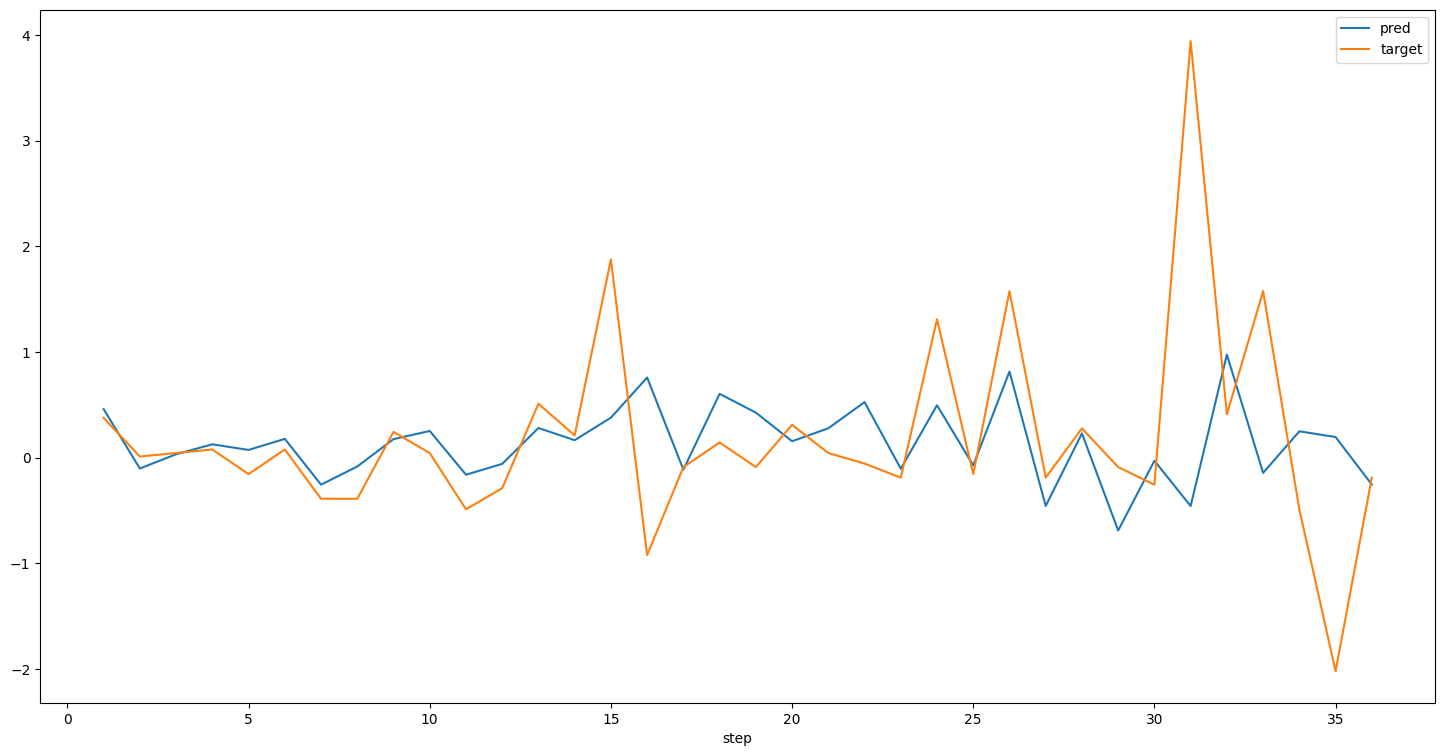

In [139]:
df_pred_vs_target.plot(x='step', y=['pred', 'target'], figsize=(18, 9))

## Examine outputs

In [33]:
X_after_train = torch.from_numpy(X_examples[228:229,:].astype('float32')).to(device=device).reshape(-1, 50 , 1)
y_after_train = y_examples[228:229]

In [34]:
output_after_train = xlstmtime(X_after_train)

In [35]:
output_after_train[:,-1,:]

tensor([[2171.7285]], device='cuda:0', grad_fn=<SliceBackward0>)

In [36]:
y_after_train

array([2151.])

In [38]:
X_examples[228:229,:]

array([[2384.5, 2350. , 2240.5, 2257. , 2266. , 2260.5, 2260. , 2241. ,
        2255. , 2142. , 2134. , 2140. , 2165. , 2142. , 2105.5, 2123.5,
        2108. , 2125. , 2163.5, 2150. , 2118. , 2142. , 2158. , 2159. ,
        2170. , 2132. , 2159. , 2183.5, 2170. , 2122.5, 2080. , 2100.5,
        2123.5, 2097. , 2070.5, 2145. , 2192. , 2117. , 2140. , 2152.5,
        2178. , 2202.5, 2196.5, 2213. , 2194. , 2195. , 2168. , 2136. ,
        2143.5, 2185.5]])

In [40]:
X_examples[229:231,:]

array([[2350. , 2240.5, 2257. , 2266. , 2260.5, 2260. , 2241. , 2255. ,
        2142. , 2134. , 2140. , 2165. , 2142. , 2105.5, 2123.5, 2108. ,
        2125. , 2163.5, 2150. , 2118. , 2142. , 2158. , 2159. , 2170. ,
        2132. , 2159. , 2183.5, 2170. , 2122.5, 2080. , 2100.5, 2123.5,
        2097. , 2070.5, 2145. , 2192. , 2117. , 2140. , 2152.5, 2178. ,
        2202.5, 2196.5, 2213. , 2194. , 2195. , 2168. , 2136. , 2143.5,
        2185.5, 2151. ],
       [2240.5, 2257. , 2266. , 2260.5, 2260. , 2241. , 2255. , 2142. ,
        2134. , 2140. , 2165. , 2142. , 2105.5, 2123.5, 2108. , 2125. ,
        2163.5, 2150. , 2118. , 2142. , 2158. , 2159. , 2170. , 2132. ,
        2159. , 2183.5, 2170. , 2122.5, 2080. , 2100.5, 2123.5, 2097. ,
        2070.5, 2145. , 2192. , 2117. , 2140. , 2152.5, 2178. , 2202.5,
        2196.5, 2213. , 2194. , 2195. , 2168. , 2136. , 2143.5, 2185.5,
        2151. , 2143. ]])

In [5]:
left_t = torch.randn(1, 50, 1)
right_t = torch.randn(1, 1, 1)

res_t = torch.cat((left_t, right_t), dim=1)[:, 1:, :]

In [6]:
res_t.shape

torch.Size([1, 50, 1])